# 1. Data Load & Processing

In [1]:
if (!requireNamespace("tidyverse", quietly = TRUE)) {install.packages("MatchIt")}
library(tidyverse)

if (!requireNamespace("dplyr", quietly = TRUE)) {install.packages("MatchIt")}
library(dplyr)

if (!requireNamespace("readxl", quietly = TRUE)) {install.packages("MatchIt")}
library(readxl)

if (!requireNamespace("reshape2", quietly = TRUE)) {install.packages("MatchIt")}
library(reshape2)

if (!requireNamespace("MatchIt", quietly = TRUE)) {install.packages("MatchIt")}
library(MatchIt)

if (!requireNamespace("lmtest", quietly = TRUE)) {install.packages("lmtest")}
library(lmtest)

if (!requireNamespace("sandwich", quietly = TRUE)) {install.packages("sandwich")}
library(sandwich)

if (!requireNamespace("gbm", quietly = TRUE)) {install.packages("sandwich")}
library(gbm)

options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 200)

Warning message:
"package 'tidyverse' was built under R version 4.3.2"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'tidyr' was built under R version 4.3.2"
Warning message:
"package 'readr' was built under R version 4.3.2"
Warning message:
"package 'purrr' was built under R version 4.3.2"
Warning message:
"package 'forcats' was built under R version 4.3.2"
Warning message:
"package 'lubridate' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become er

### 1.a. Processing World Bank indicators

In [2]:
# Read indicators from World Bank
wb_indicators_raw <- read_excel("Data\\WDI - WorldBank\\Indicators.xlsx", sheet = "Data")
# Melt dataset to put years to rows
wb_indicators_melted <- melt(wb_indicators_raw, id.vars = c("Country Name", "Country Code", "Series Code", "Series Name"), 
                  variable.name = "Year", value.name = "Value")
# Convert the 'Value' column to numeric, coerce errors
wb_indicators_melted$Value <- as.numeric(as.character(wb_indicators_melted$Value))
# Clean and convert the 'Year' column to numeric
wb_indicators_melted$Year <- gsub("\\[.*\\]", "", wb_indicators_melted$Year)
wb_indicators_melted$Year <- as.numeric(wb_indicators_melted$Year)
# Drop NAs
wb_indicators_long <- na.omit(wb_indicators_melted)
# Convert to wide format, representing each indicator as a column
wb_indicators_wide <- pivot_wider(wb_indicators_long, 
                          id_cols = c("Country Name", "Country Code", "Year"),  # List the columns you want to keep as base dimensions
                          names_from = "Series Code", 
                          values_from = "Value")
# Rename columns
wb_indicators_wide <- wb_indicators_wide %>%
        rename(!!!setNames(c("Country Name", "Country Code", "Year"), c("country", "country_code", "year")))
# Column name mapping
wb_indicators_mapping <- c(
  "gdp_per_capita" = "NY.GDP.PCAP.CD",
  "gdp_per_capita_growth_pct" = "NY.GDP.PCAP.KD.ZG",
  "agriculture_pct_gdp" = "NV.AGR.TOTL.ZS",
  "industry_pct_gdp" = "NV.IND.TOTL.ZS",
  "pop_total" = "SP.POP.TOTL",
  "pop_in_largest_city_pct_of_urban_pop" = "EN.URB.LCTY.UR.ZS",
  "pop_growth_pct" = "SP.POP.GROW",
  "pop_density" = "EN.POP.DNST",
  "pop_urban" = "SP.URB.TOTL",
  "pop_urban_pct_of_total" = "SP.URB.TOTL.IN.ZS",
  "pop_rural" = "SP.RUR.TOTL",
  "pop_rural_pct_of_total" = "SP.RUR.TOTL.ZS",
  "gni" = "NY.GDY.TOTL.KN"
)
# Apply remapping of column names
wb_indicators_wide <- wb_indicators_wide %>%
  rename(!!!wb_indicators_mapping)
# Generate a binary future for negative gdp growth
wb_indicators_wide <- wb_indicators_wide %>%
  mutate(recession_binary = if_else(is.na(gdp_per_capita_growth_pct), NA_real_,
  if_else(gdp_per_capita_growth_pct < 0, 1, 0)))
# Sort dataset
wb_indicators_final <- wb_indicators_wide %>% arrange (country, year)
# Check final dataset
print(dim(wb_indicators_final))
head(wb_indicators_final)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


[1] 5232   17


country,country_code,year,gdp_per_capita,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_total,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_density,pop_urban,pop_urban_pct_of_total,pop_rural,pop_rural_pct_of_total,gni,recession_binary
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,AFG,2004,221.8305,-2.497255,29.72107,26.22679,23553551,53.47740,3.933178,36.11234,5299549,22.500,18254002,77.500,NA,1
Afghanistan,AFG,2005,254.1153,7.321874,31.11485,26.81210,24411191,52.42042,3.576508,37.42727,5542073,22.703,18869118,77.297,NA,0
Afghanistan,AFG,2006,274.0154,1.084988,28.63597,28.21077,25442944,51.09937,4.139678,39.00916,5828215,22.907,19614729,77.093,NA,0
Afghanistan,AFG,2007,376.3183,11.803383,30.10501,26.88224,25903301,50.99387,1.793196,39.71498,5987030,23.113,19916271,76.887,NA,0
Afghanistan,AFG,2008,382.5338,1.864754,24.89227,26.91563,26427199,50.78588,2.002333,40.51822,6162823,23.320,20264376,76.680,NA,0
Afghanistan,AFG,2009,453.3874,17.143534,29.29750,21.89712,27385307,49.79475,3.561288,41.98719,6443215,23.528,20942092,76.472,NA,0


### 1.b. Processing weather variables

In [3]:
# Read weather datasets
precipitation_raw = read_csv("Data\\Weather\\GDL-Total-Yearly-Precipitation-data.csv", col_types = cols())
humidity_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Relative-Humidity-data.csv", col_types = cols())
avg_surface_temp_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Surface-Temperature-(ºC)-data.csv", col_types = cols())
# Common fuction to melt and clean weather datasets
clean_weather_datasets <- function (df, measure) {
    # Melt dataset to put years to rows
    df_melted <- melt(df, id.vars = c("Country", "Continent", "ISO_Code", "Level", "GDLCODE", "Region"), 
                    variable.name = "Year", value.name = "Value")
    # Convert the 'Value' column to numeric, coerce errors
    df_melted[measure] <- as.numeric(df_melted$Value)
    # Clean and convert the 'Year' column to numeric
    df_melted$Year <- as.numeric(as.character(df_melted$Year))
    # Drop NAs
    df_final <- na.omit(df_melted)
    # Drop unnecassary columns
    cols_to_drop <- c("Continent", "Level", "GDLCODE", "Region", "Value")
    df_final <- df_final %>% select(-one_of(cols_to_drop))
    # Rename columns
    df_final <- df_final %>%
        rename(!!!setNames(c("Country", "ISO_Code", "Year"), c("country", "country_code", "year")))
    # Return cleaned dataframe
    return (df_final)
    }
# Melt and clean weather datasets
precipitation_final <- clean_weather_datasets(precipitation_raw, "precipitation")
humidity_final <- clean_weather_datasets(humidity_raw, "humidity")
avg_surface_temp_final <- clean_weather_datasets(avg_surface_temp_raw, "avg_surface_temp")
# Check dimensions before join
print(paste0("precipitation_final: " ,dim(precipitation_final)[1], " rows"))
print(paste0("humidity_final: " ,dim(humidity_final)[1], " rows"))
print(paste0("avg_surface_temp_final: " ,dim(avg_surface_temp_final)[1], " rows"))
# Inner join precipitation, humidity and avg surface temperature datasets
weather_joined <- inner_join(precipitation_final, humidity_final, by = c("country", "country_code", "year")) %>%
             inner_join(avg_surface_temp_final, by = c("country", "country_code", "year"))
# Check dimensions after inner join
print(paste0("weather_joined: " ,dim(weather_joined)[1], " rows"))
# Remap country codes to right names and remove duplication on country names
country_remap = c(
  "REU" = "Réunion", # Country was France
  "GUF" = "French Guiana", # Country was France
  "MYT" = "Mayotte", # Country was France
  "TWN" = "Taiwan", # Country was China
  "Z06" = "Unknown1", # Country was Pakistan
  "PRK" = "Unknown2" # Country was Pakistan
)
# Apply the country remap to the country column based on matches with country_code
weather_joined_mapped <- weather_joined %>%
  mutate(country = if_else(country_code %in% names(country_remap), 
                           country_remap[country_code], 
                           country))
# Sort dataset
weather_final <- weather_joined_mapped %>% arrange(country, year)
# Check dataset
print(dim(weather_final))
head(weather_final)

[1] "precipitation_final: 6666 rows"
[1] "humidity_final: 6666 rows"
[1] "avg_surface_temp_final: 6666 rows"
[1] "weather_joined: 6666 rows"
[1] 6666    6


,country,country_code,year,precipitation,humidity,avg_surface_temp
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,AFG,1990,0.016,46.92,9.466
2,Afghanistan,AFG,1991,0.021,50.84,8.369
3,Afghanistan,AFG,1992,0.019,49.57,8.203
4,Afghanistan,AFG,1993,0.014,46.11,8.754
5,Afghanistan,AFG,1994,0.017,48.90,8.812
6,Afghanistan,AFG,1995,0.016,45.20,8.728


### 1.c. Processing EU ETS variables

In [4]:
# Read EU ETS database
eu_ets_raw = read.csv("Data\\EU ETS\\ETS_Database_Jul23.csv", sep = "\t", na.strings = "", fileEncoding = "UTF-8")
# Define the mapping of old names to new names for EUAs
eua_breakdown <- c(
  "1. Total allocated allowances (EUA or EUAA)" = "total_EUAs",
  "1.1 Freely allocated allowances" = "free_EUAs",
  "1.2 Correction to freely allocated allowances (not reflected in EUTL)" = "free_correction_EUAs",
  "1.3 Allowances auctioned or sold (EUAs and EUAAs)" = "auctioned_sold_EUAs"
)
# Drop unnecassary information columns, 
# keep only total EUAs, freely allocated EUAs, correction to freely allocated EUAs and EUAs auctioned or sold
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(ETS.information %in% names(eua_breakdown)) %>%
  mutate(ETS.information = case_when(
    ETS.information %in% names(eua_breakdown) ~ eua_breakdown[ETS.information],
    TRUE ~ ETS.information
  ))
# Define the mapping of old names to new names for sector breakdown
sector_breakdown <- c(
    "20-99 All stationary installations" = "all_stationary",
    "10 Aviation" = "aviation")
# Drop sector breakdown, just include all stationary installations and aviation
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(main.activity.sector.name %in% names(sector_breakdown)) %>%
  mutate(main.activity.sector.name = case_when(
    main.activity.sector.name %in% names(sector_breakdown) ~ sector_breakdown[main.activity.sector.name],
    TRUE ~ main.activity.sector.name
  ))
# Remove period aggregates and keep years only
eu_ets_raw <- eu_ets_raw %>% filter(nchar(year) == 4)
# Convert to wide format, representing each EUA breakdown as a column
eu_ets_wide <- pivot_wider(eu_ets_raw, 
                          id_cols = c("country", "country_code", "year"),  # List the columns you want to keep as base dimensions
                          names_from = "ETS.information", 
                          values_from = "value",
                          values_fn = sum)
# Fill NAs with 0
eu_ets_wide[is.na(eu_ets_wide)] <- 0
# Convert year column to numeric
eu_ets_wide$year <- as.numeric(eu_ets_wide$year)
# Apply correction to freely allocated EUAs
eu_ets_wide$free_EUAs <- eu_ets_wide$free_EUAs + eu_ets_wide$free_correction_EUAs
# Drop correction to freely allocated EUAs column
eu_ets_wide$free_correction_EUAs <- NULL
# Rename Northen Ireland to UK
eu_ets_wide$country <- ifelse(eu_ets_wide$country %in% c("United Kingdom (excl. NI)", "Northern Ireland"), "United Kingdom", eu_ets_wide$country)
eu_ets_wide$country_code <- ifelse(eu_ets_wide$country == "United Kingdom", "UK", eu_ets_wide$country_code)
# Aggregate Northen Ireland to UK
eu_ets_final <- eu_ets_wide %>% 
  group_by(country, country_code, year) %>% 
  summarize(
    free_EUAs = sum(free_EUAs),
    total_EUAs = sum(total_EUAs),
    auctioned_sold_EUAs = sum(auctioned_sold_EUAs)
  )
# Sort dataset by country and year
eu_ets_final <- eu_ets_final %>% arrange(country, year)
# Check dataset
print(dim(eu_ets_final))
head(eu_ets_final)

`summarise()` has grouped output by 'country', 'country_code'. You can override
using the `.groups` argument.


[1] 605   6


country,country_code,year,free_EUAs,total_EUAs,auctioned_sold_EUAs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,AT,2005,32412654,32412654,0
Austria,AT,2006,32649366,32649366,0
Austria,AT,2007,32729289,32729289,0
Austria,AT,2008,30718182,30718182,0
Austria,AT,2009,30313132,30718182,405050
Austria,AT,2010,30563812,30963812,400000


### 1.d. Processing PM2.5 variables

In [5]:
# Read PM2.5 data from WHO
pm25_raw = read.csv("Data\\WHO PM2.5\\SDG Indicator 11.6.2. Concentrations of PM2.5.csv")
# Define the mapping of old names to new names for the whole dataset
pm25_columns_old <- c("SpatialDimValueCode", "Location", "Period", "Dim1", "FactValueNumeric")
pm25_columns_new <- c("country_code", "country", "year", "residence_area", "PM25")
# Drop unnecessary columns
pm25_raw <- pm25_raw %>% select(all_of(pm25_columns_old))
# Rename respective columns
pm25_raw <- pm25_raw %>% rename(!!!setNames(pm25_columns_old,pm25_columns_new))
# Convert to long format, also pulling residence area breakdown to columns
pm25_long <- pm25_raw %>%
  pivot_wider(names_from = residence_area,
              values_from = c(PM25),
              names_glue = "{.value}_{residence_area}")
# Sort dataset
pm25_final <- pm25_long %>% arrange (country,year)
# Check dataset
print(dim(pm25_final))
head(pm25_final)
# pm25_long[(pm25_long$country_code == "DEU"),]

[1] 1950    8


country_code,country,year,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,2010,92.79,61.81,68.97,69.67,83.13
AFG,Afghanistan,2011,89.57,60.11,66.94,67.72,80.45
AFG,Afghanistan,2012,92.04,61.09,68.26,68.88,82.40
AFG,Afghanistan,2013,97.49,64.50,72.18,73.01,87.33
AFG,Afghanistan,2014,91.92,60.79,68.06,68.85,82.36
AFG,Afghanistan,2015,90.88,59.99,67.20,67.90,81.38


### 1.e. Combining datasets

In [6]:
# A common function to remap country names to be consistent across data sources
map_countries <- function(df, column_to_map) {
  mapping_dict <- c(
    "Argentina urban" = "Argentina",
    "Bahamas, The" = "Bahamas",
    "Bolivia (Plurinational State of)" = "Bolivia",
    "Cape Verde" = "Cabo Verde",
    "Central African Republic CAR" = "Central African Republic",
    "Chili" = "Chile",
    "Congo Democratic Republic" = "Congo, Dem. Rep.",
    "Democratic Republic of the Congo" = "Congo, Dem. Rep.",
    "Czech Republic" = "Czechia",
    "Egypt, Arab Rep." = "Egypt",
    "Gambia, The" = "Gambia",
    "Guinea Bissau" = "Guinea-Bissau",
    "Iran (Islamic Republic of)" = "Iran",
    "Iran, Islamic Rep." = "Iran",
    "Democratic People's Republic of Korea" = "North Korea",
    "Korea, Dem. People's Rep." = "North Korea",
    "Korea, Rep." = "Korea",
    "Republic of Korea" = "Korea",
    "Kyrgyz Republic" = "Kyrgyzstan",
    "Lao People's Democratic Republic" = "Lao",
    "Lao PDR" = "Lao",
    "Micronesia (Federated States of)" = "Micronesia, Fed. Sts.",
    "Monte Negro" = "Montenegro",
    "Republic of Moldova" = "Moldova",
    "Sao Tome & Principe" = "Sao Tome and Principe",
    "Slovak Republic" = "Slovakia",
    "Syrian Arab Republic" = "Syria",
    "The former Yugoslav Republic of Macedonia" = "North Macedonia",
    "Timor-Leste" = "Timor Leste",
    "Trinidad & Tobago" = "Trinidad and Tobago",
    "Türkiye" = "Turkey",
    "Turkiye" = "Turkey",
    "United States of America" = "United States",
    "Venezuela (Bolivarian Republic of)" = "Venezuela",
    "Venezuela, RB"  = "Venezuela",
    "Viet Nam" = "Vietnam",
    "Yemen, Rep." = "Yemen",
    "United Kingdom of Great Britain and Northern Ireland" = "United Kingdom"
  )
  
  df[[column_to_map]] <- ifelse(df[[column_to_map]] %in% names(mapping_dict), 
                                mapping_dict[df[[column_to_map]]], 
                                df[[column_to_map]])
  
  return(df)
}

# Map country names in each dataset
pm25_final_mapped <- map_countries(pm25_final, "country")
eu_ets_final_mapped <- map_countries(eu_ets_final, "country")
weather_final_mapped <- map_countries(weather_final, "country")
wb_indicators_final_mapped <- map_countries(wb_indicators_final, "country")

# Join each dataset, keeping PM2.5 dataset as the main one to join on
all_indicators <- merge(pm25_final_mapped, subset(eu_ets_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(weather_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(wb_indicators_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE)

print(dim(all_indicators))
head(all_indicators)

[1] 1950   28


,year,country,country_code,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban,free_EUAs,total_EUAs,⋯,pop_total,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_density,pop_urban,pop_urban_pct_of_total,pop_rural,pop_rural_pct_of_total,gni,recession_binary
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010,Afghanistan,AFG,92.79,61.81,68.97,69.67,83.13,NA,NA,⋯,28189672,49.15285,2.894904,43.22045,6691382,23.737,21498290,76.263,NA,0
2,2010,Albania,ALB,22.24,21.38,21.95,22.37,22.30,NA,NA,⋯,2913021,26.89647,-0.496462,106.31464,1519519,52.163,1393502,47.837,1.239645e+12,0
3,2010,Algeria,DZA,21.67,21.72,21.27,20.29,21.02,NA,NA,⋯,35856344,10.04247,1.858702,15.05468,24217375,67.540,11638969,32.460,1.405517e+13,0
4,2010,Andorra,AND,NA,10.53,11.43,11.88,11.88,NA,NA,⋯,71519,NA,-3.209994,152.16809,63522,88.819,7997,11.181,NA,0
5,2010,Angola,AGO,27.20,23.59,24.20,24.33,26.53,NA,NA,⋯,23364185,37.94772,3.734798,18.74082,13967811,59.783,9396374,40.217,1.296739e+12,0
6,2010,Antigua and Barbuda,ATG,NA,7.99,8.17,8.29,8.29,NA,NA,⋯,85695,NA,1.364066,194.76136,22485,26.238,63210,73.762,NA,1


# 2. EDA, data cleaning and feature engineering

### 2.a. Gap analysis, summmary statistics

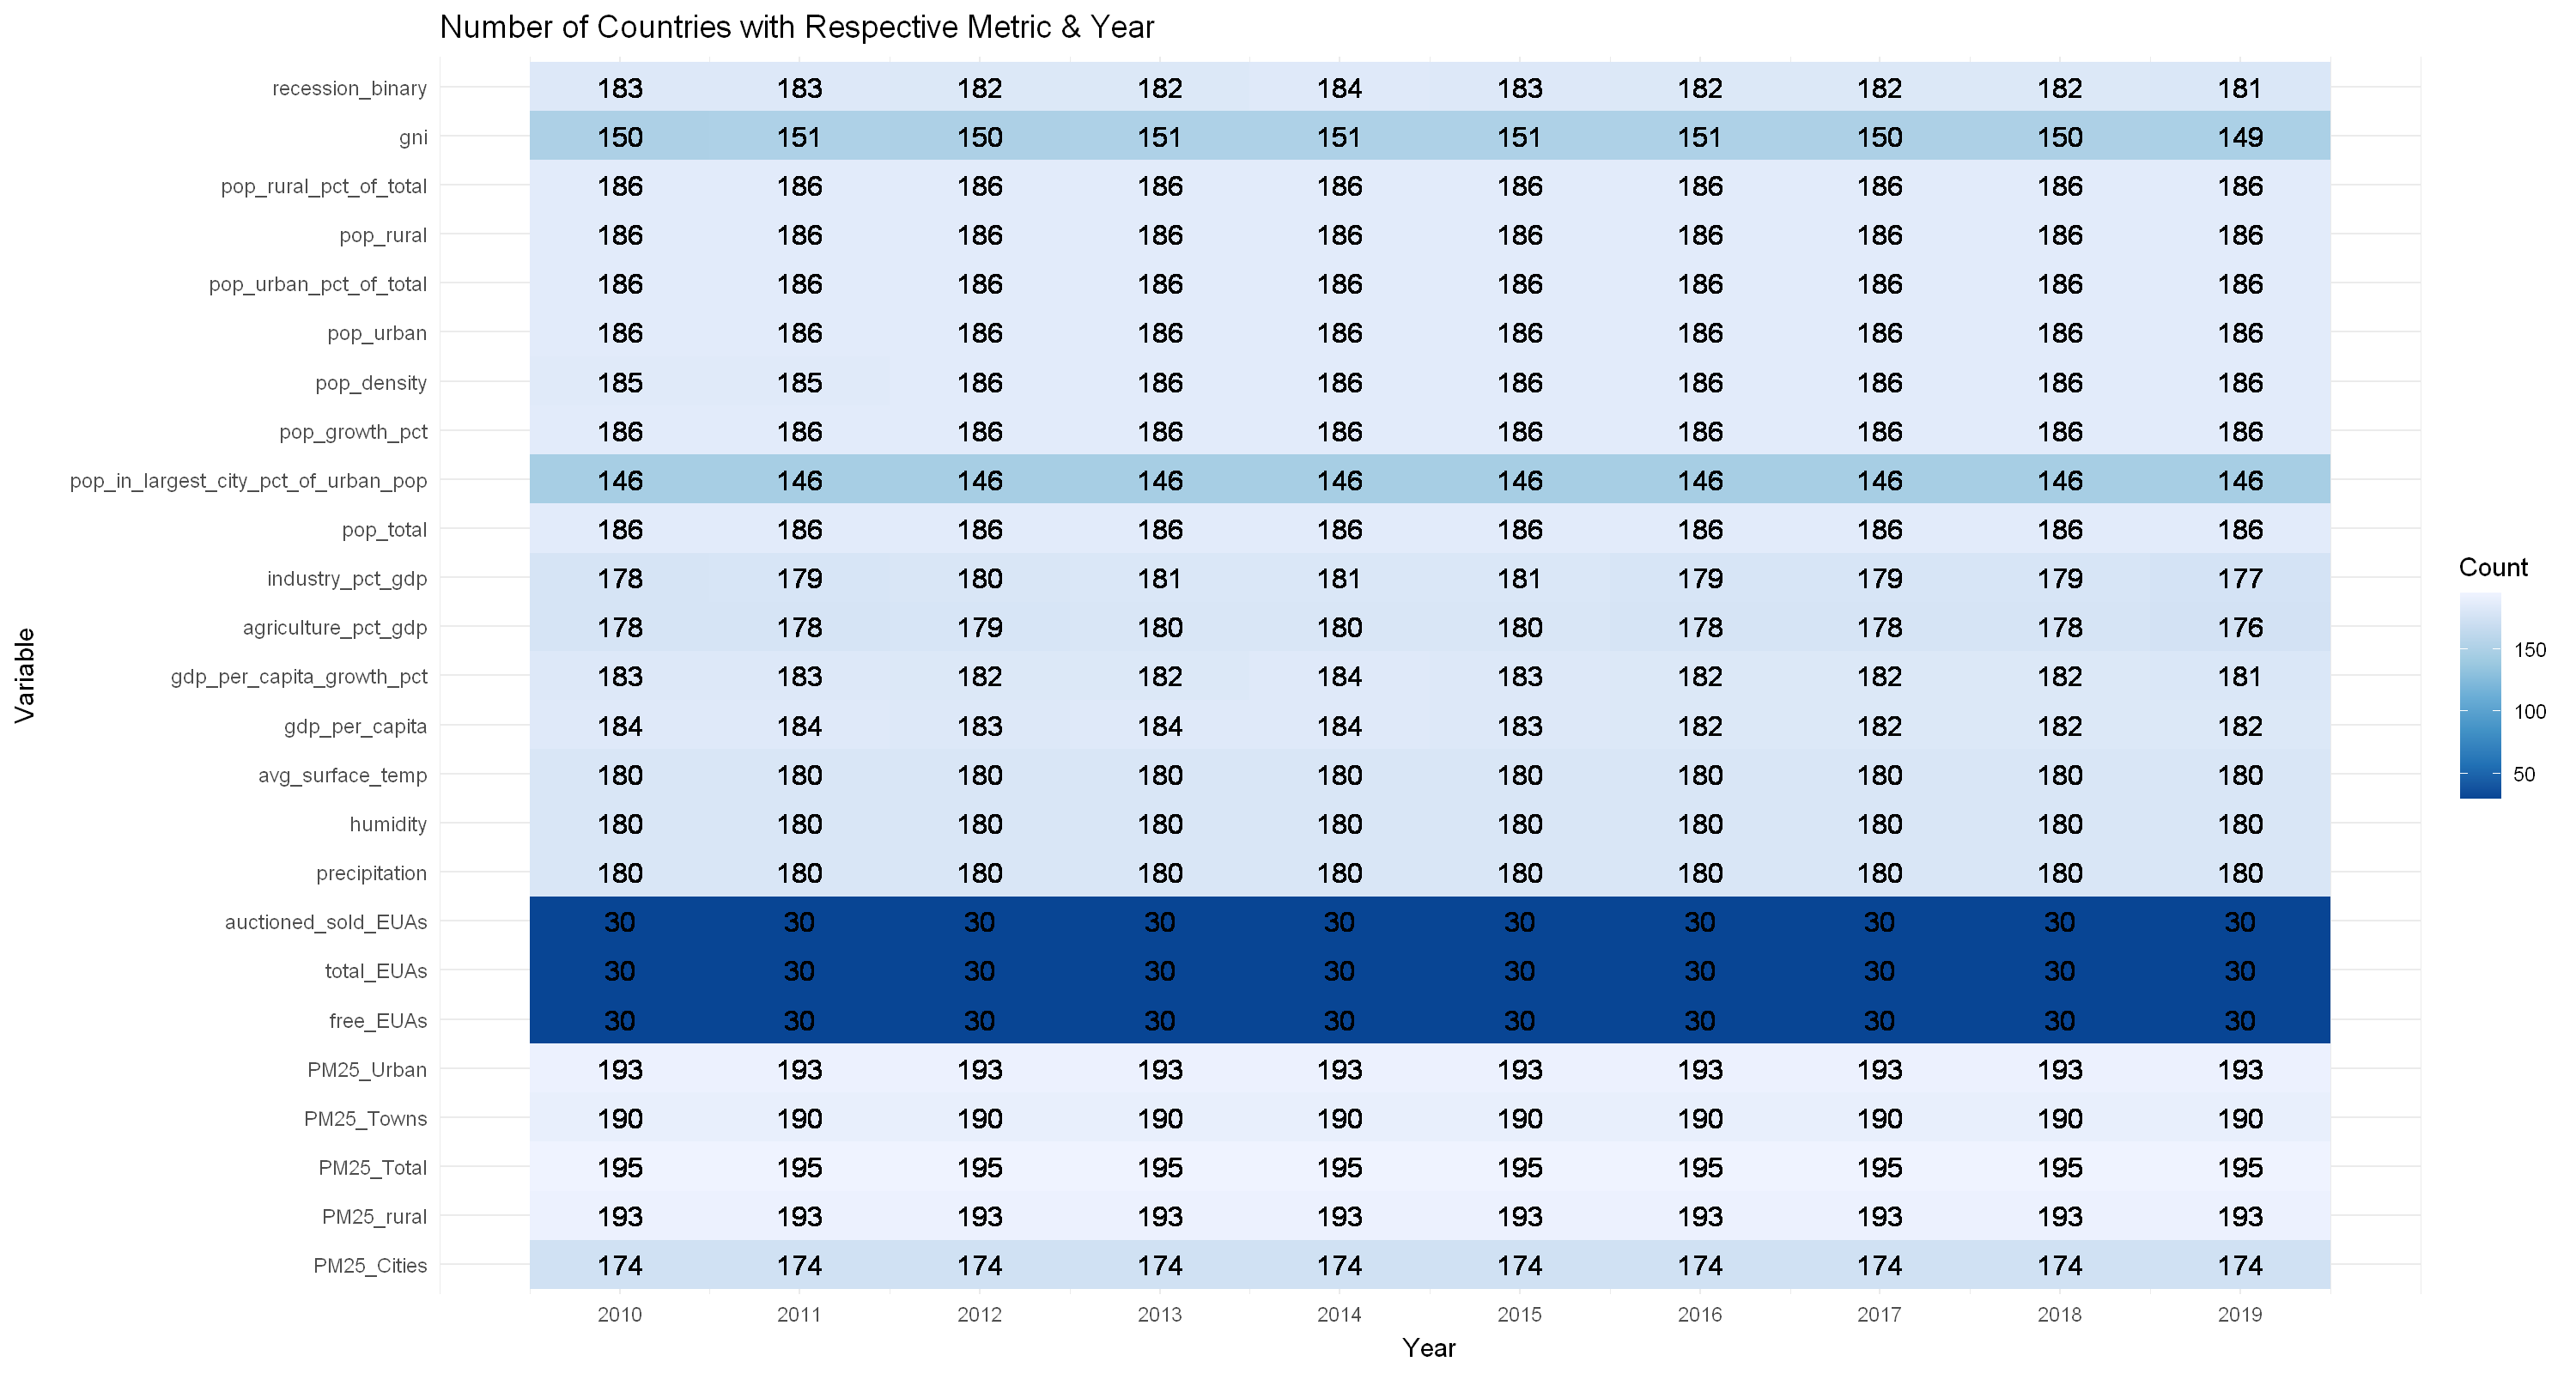

In [7]:

# Calculate the number of non-NA values for each column
non_na_counts <- all_indicators %>%
  select(-c(country,country_code)) %>%
  group_by(year) %>%
  mutate(across(everything(), ~sum(!is.na(.))))
  
# Reshape the data for plotting while retaining column order
non_na_counts_long <- non_na_counts %>%
  pivot_longer(cols = -year, names_to = "variable", values_to = "count") %>%
  mutate(variable = factor(variable, levels = colnames(non_na_counts)[-1]))  # Exclude the "year" column from levels

non_na_counts_long$variable <- factor(non_na_counts_long$variable, levels = 
  names(all_indicators)[!names(all_indicators) %in% c("year", "country", "country_code")])

# Create the heatmap
heatmap_plot <- ggplot(data = non_na_counts_long, aes(x = year, y = variable, fill = count)) +
  geom_tile() +
  scale_fill_distiller() +  # Choose color palette
  geom_text(aes(label = ifelse(is.na(count), "", count)), size = 4, color = "black") +  # Add text labels with small font
  scale_x_continuous(breaks = seq(min(non_na_counts$year), max(non_na_counts$year), by = 1)) +  # Display integer values on X-axis
  labs(title = "Number of Countries with Respective Metric & Year",
       x = "Year",
       y = "Variable",
       fill = "Count") +
  theme_minimal()
# Display the heatmap
print(heatmap_plot)

In [8]:
# Check column summaries
summary(all_indicators)

      year        country          country_code        PM25_Cities   
 Min.   :2010   Length:1950        Length:1950        Min.   : 4.59  
 1st Qu.:2012   Class :character   Class :character   1st Qu.:14.51  
 Median :2014   Mode  :character   Mode  :character   Median :22.31  
 Mean   :2014                                         Mean   :27.03  
 3rd Qu.:2017                                         3rd Qu.:36.49  
 Max.   :2019                                         Max.   :97.49  
                                                      NA's   :210    
   PM25_rural      PM25_Total      PM25_Towns      PM25_Urban   
 Min.   : 4.92   Min.   : 4.92   Min.   : 5.22   Min.   : 4.92  
 1st Qu.:10.48   1st Qu.:11.39   1st Qu.:11.60   1st Qu.:12.15  
 Median :17.71   Median :18.81   Median :18.77   Median :19.77  
 Mean   :21.24   Mean   :22.67   Mean   :22.82   Mean   :24.27  
 3rd Qu.:28.24   3rd Qu.:29.86   3rd Qu.:29.89   3rd Qu.:32.18  
 Max.   :67.74   Max.   :72.18   Max.   :73.01   M

### 2.b. Data cleaning

In [9]:
# 0 precipitation seems like a data quality issue, therefore dropping respective row.
all_indicators_filtered <- all_indicators %>% filter (precipitation > 0)
# Adjust negative and zero average surface temperature records to be positive
# So that we can apply log transformation
all_indicators_filtered$avg_surface_temp <- all_indicators_filtered$avg_surface_temp + abs(min(all_indicators_filtered$avg_surface_temp, na.rm = TRUE)) + 1
# Fill NAs for EUETS columns with 1, add 1 to all other records
all_indicators_filtered <- all_indicators_filtered %>%
  mutate_at(vars(free_EUAs, total_EUAs, auctioned_sold_EUAs),  # Select columns
           ~ .x %>% replace(is.na(.x), 0) + 1)  # Replace NA with 0, add 1
# gdp_per_capita_growth_pct spans between -48% to 96%
# Trimming only 0.1% from each ends of the distribution to remove outliers
lower_quantile <- quantile(all_indicators_filtered$gdp_per_capita_growth_pct, probs = 0.001, na.rm = TRUE)
upper_quantile <- quantile(all_indicators_filtered$gdp_per_capita_growth_pct, probs = 0.999, na.rm = TRUE)
all_indicators_filtered$gdp_per_capita_growth_pct[all_indicators_filtered$gdp_per_capita_growth_pct < lower_quantile | 
                                          all_indicators_filtered$gdp_per_capita_growth_pct > upper_quantile] <- NA

### 2.c. Feature engineering

In [10]:
# Apply log transformation for all columns except percentages
all_indicators_filtered <- all_indicators_filtered %>%
  mutate_at(vars(PM25_Cities, PM25_rural, PM25_Total, PM25_Towns, PM25_Urban,
                 gdp_per_capita, gni, pop_total, pop_density, pop_urban, pop_rural,
                 precipitation, humidity, avg_surface_temp,
                 free_EUAs, total_EUAs, auctioned_sold_EUAs), 
             list(log = ~log(.)))
# Drop the original columns that log transformation is applied
all_indicators_filtered <- all_indicators_filtered %>%
  select(-PM25_Cities, -PM25_rural, -PM25_Total, -PM25_Towns, -PM25_Urban,
         -gdp_per_capita, -gni, -pop_total, -pop_density, -pop_urban, -pop_rural,
         -precipitation, -humidity, -avg_surface_temp,
         -free_EUAs, -total_EUAs, -auctioned_sold_EUAs)

# Label EU ETS country-year records
all_indicators_filtered$is_eu_ets <- ifelse(all_indicators_filtered$free_EUAs_log>0 | all_indicators_filtered$auctioned_sold_EUAs_log >0,TRUE,FALSE)

# Drop unnecassary indicators (for now)
all_indicators_filtered <- all_indicators_filtered %>% select(-c(gni_log,pop_rural_log,pop_urban_log,total_EUAs_log))

# Check final dataset
print(dim(all_indicators_filtered))
head(all_indicators_filtered)

[1] 1799   25


,year,country,country_code,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_urban_pct_of_total,pop_rural_pct_of_total,⋯,PM25_Urban_log,gdp_per_capita_log,pop_total_log,pop_density_log,precipitation_log,humidity_log,avg_surface_temp_log,free_EUAs_log,auctioned_sold_EUAs_log,is_eu_ets
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,2010,Afghanistan,AFG,11.0992199,26.2100685,21.15142,49.15285,2.894904,23.737,76.263,⋯,4.420406,6.332390,17.15447,3.766314,-4.199705,3.771611,2.500534,0,0,FALSE
2,2010,Albania,ALB,4.2230838,17.9558664,24.93746,26.89647,-0.496462,52.163,47.837,⋯,3.104587,8.317363,14.88470,4.666403,-2.764621,4.284827,2.681638,0,0,FALSE
3,2010,Algeria,DZA,1.6921701,8.4664436,49.96743,10.04247,1.858702,67.540,32.460,⋯,3.045474,8.410926,17.39503,2.711689,-4.422849,3.927699,3.020864,0,0,FALSE
4,2010,Andorra,AND,1.2226877,0.4665086,13.12565,NA,-3.209994,88.819,11.181,⋯,2.474856,10.783900,11.17772,5.024986,-3.411248,4.281792,1.779181,0,0,FALSE
5,2010,Angola,AGO,0.5712209,6.1802935,52.36844,37.94772,3.734798,59.783,40.217,⋯,3.278276,8.184978,16.96671,2.930704,-3.296837,4.152613,3.193312,0,0,FALSE
6,2010,Antigua and Barbuda,ATG,-9.0891748,1.6334085,16.20415,NA,1.364066,26.238,73.762,⋯,2.115050,9.503347,11.35855,5.271775,-3.170086,4.369195,3.345297,0,0,FALSE


### 2.d. Handling missing values

In [11]:
# Find incomplete EU ETS country-year records
eu_ets_country_year_incomplete <- all_indicators_filtered[(!complete.cases(all_indicators_filtered)) & all_indicators_filtered$is_eu_ets == TRUE, ]
# Find NA counts under each column and filter to positive columns only
eu_ets_country_year_incomplete %>%
  summarise_all(~sum(is.na(.))) %>%
  t() %>%
  as.data.frame() %>%
  filter(V1 > 0)

unique(eu_ets_country_year_incomplete$country)

,V1
,<int>
pop_in_largest_city_pct_of_urban_pop,38


[1] "Cyprus"     "Luxembourg" "Slovenia"   "Iceland"

In [13]:
all_indicators_filtered %>%
filter(is_eu_ets == TRUE) %>%
  group_by(year) %>%
  summarise (mean_eu_ets_pop_in_largest_city_pct_of_urban_pop = mean(pop_in_largest_city_pct_of_urban_pop, na.rm = TRUE))

year,mean_eu_ets_pop_in_largest_city_pct_of_urban_pop
<int>,<dbl>
2010,23.23967
2011,23.33011
2012,23.66387
2013,23.77250
2014,23.87110
2015,23.95802
2016,24.04345
2017,24.13699
2018,24.21560


In [14]:
all_indicators_filtered <- all_indicators_filtered %>%
  group_by(year) %>%
  mutate(pop_in_largest_city_pct_of_urban_pop = ifelse(
    is.na(pop_in_largest_city_pct_of_urban_pop) & is_eu_ets == TRUE,
    mean(pop_in_largest_city_pct_of_urban_pop[is_eu_ets == TRUE], na.rm = TRUE),
    pop_in_largest_city_pct_of_urban_pop
  )) %>%
  ungroup()

# Remove records with NAs
all_indicators_final <- na.omit(all_indicators_filtered)

### 2.e. Distribution of variables

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


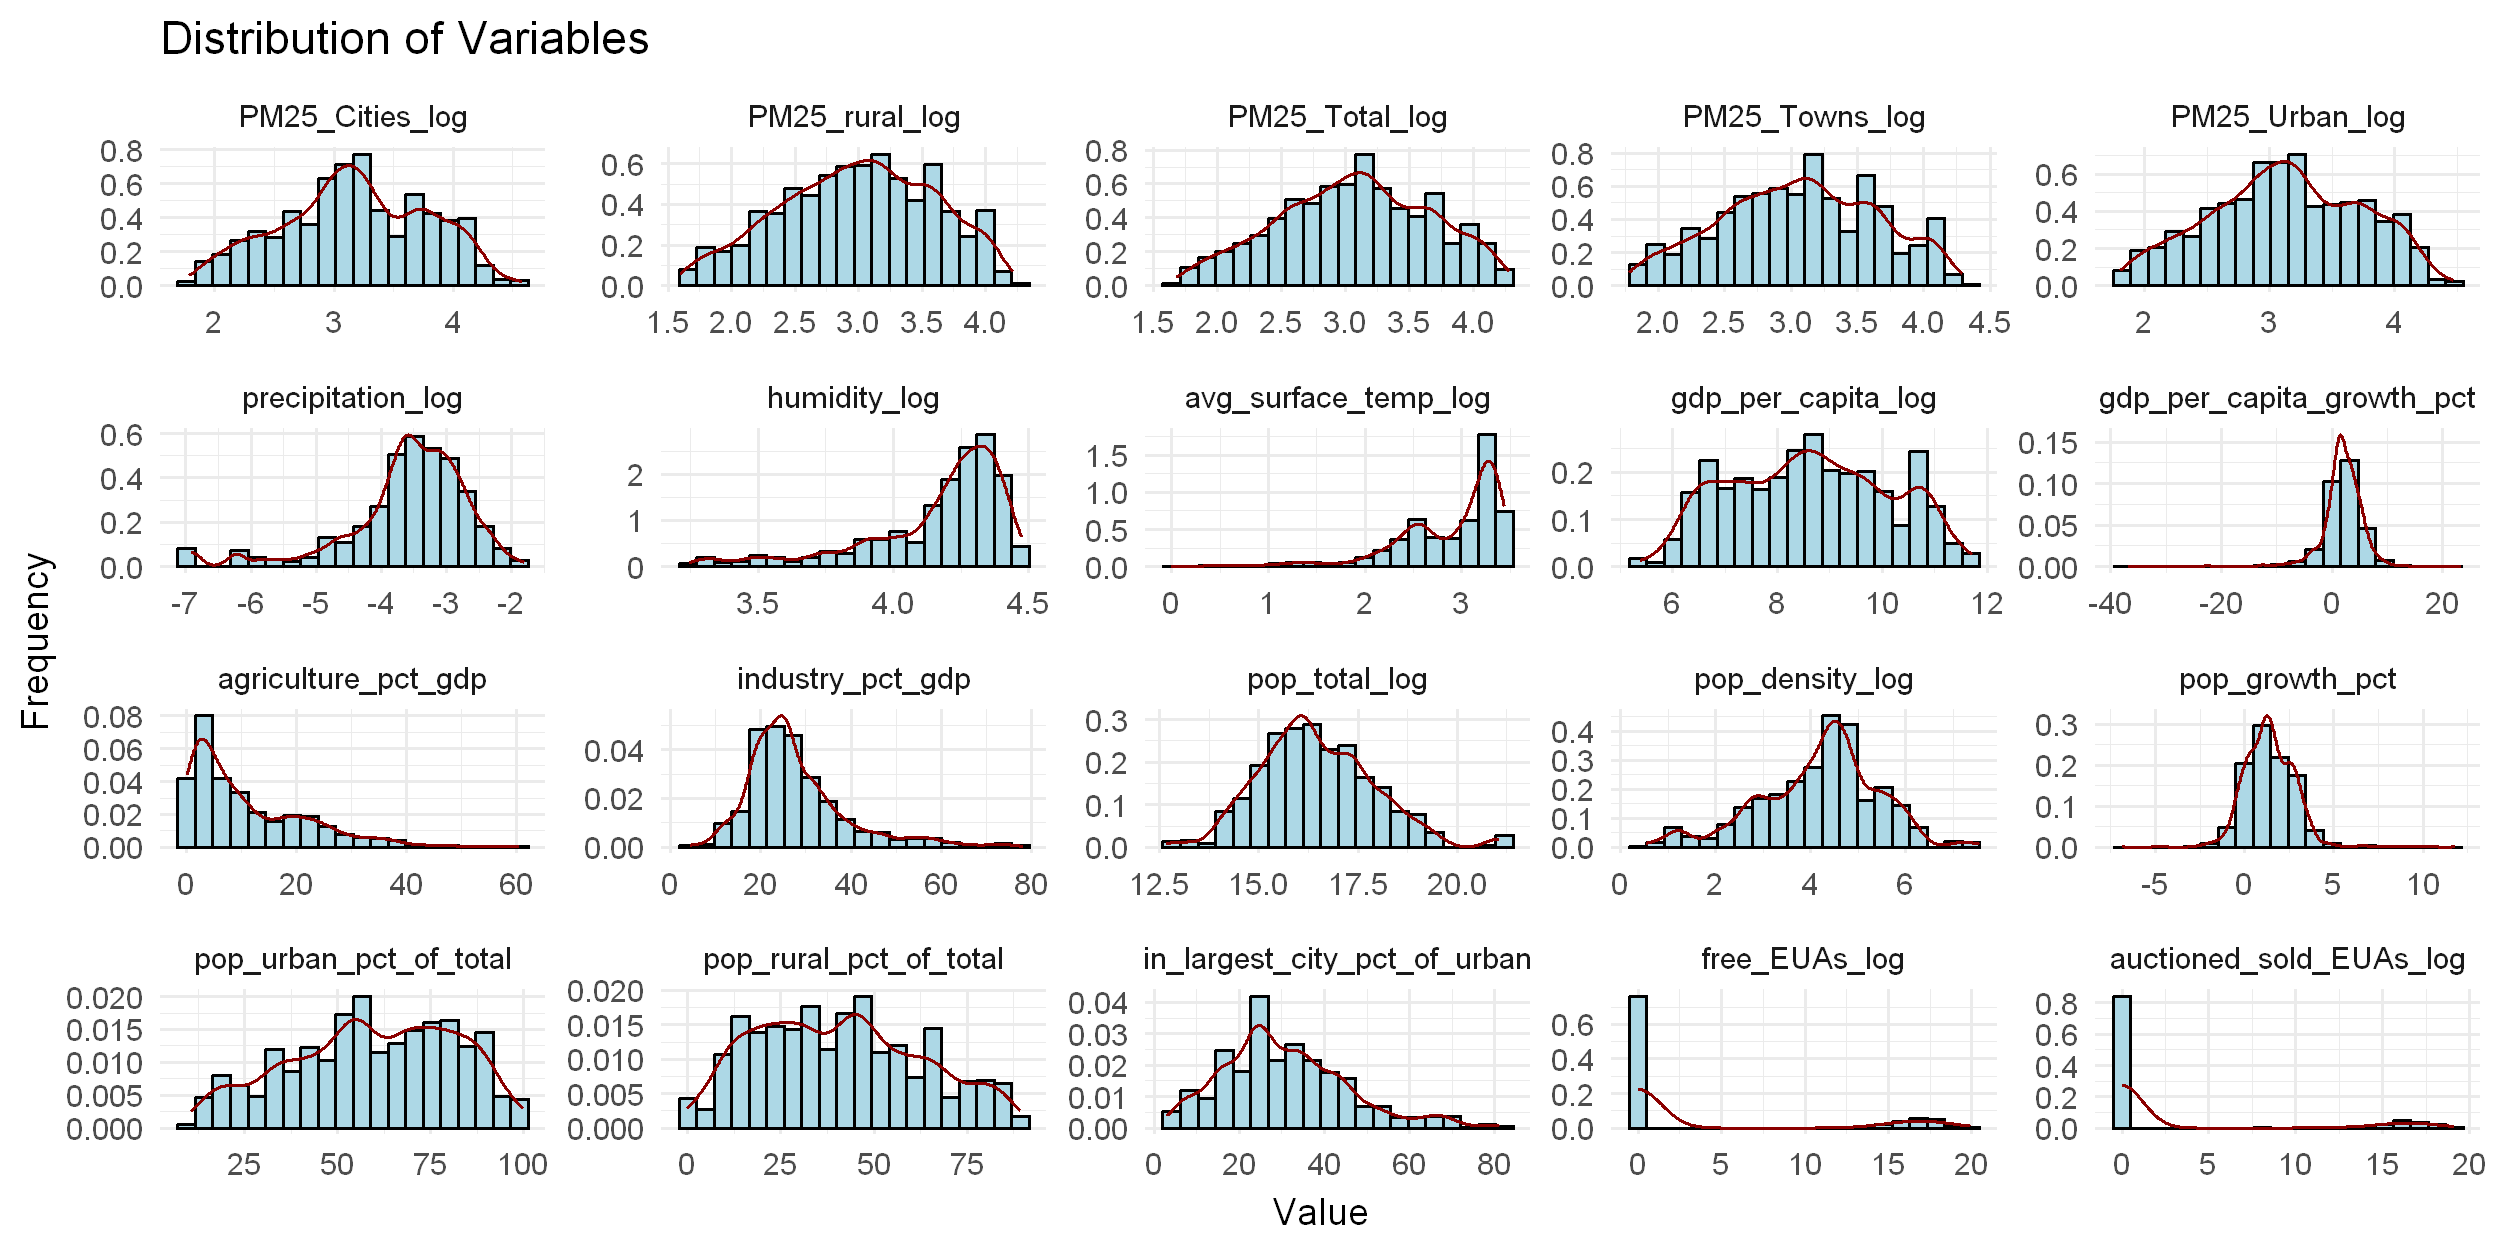

In [15]:
column_order <- c('PM25_Cities_log', 'PM25_rural_log', 'PM25_Total_log', 'PM25_Towns_log', 'PM25_Urban_log',
'precipitation_log', 'humidity_log', 'avg_surface_temp_log', 
'gdp_per_capita_log', 'gdp_per_capita_growth_pct', 'recession_binary', 'agriculture_pct_gdp', 'industry_pct_gdp', 
'pop_total_log', 'pop_density_log', 'pop_growth_pct', 'pop_urban_pct_of_total', 'pop_rural_pct_of_total', 'pop_in_largest_city_pct_of_urban_pop',
'is_eu_ets', 'free_EUAs_log', 'auctioned_sold_EUAs_log')

all_indicators_final <- all_indicators_final %>% select(all_of(c("country", "year", "country_code", column_order)))

all_indicators_final$dummyvar <- "dummyvar"  # Create a dummy variable for pivot_longer()
# Reshape the dataframe to long format
selected_variables_long <- pivot_longer(all_indicators_final[,setdiff(colnames(all_indicators_final), c("year", "country", "country_code", "recession_binary", "is_eu_ets"))], -dummyvar)
all_indicators_final$dummyvar <- NULL

# Convert 'name' to factor with levels based on original dataset order
selected_variables_long$name <- factor(selected_variables_long$name, levels = names(all_indicators_final)[!names(all_indicators_final) %in% c("year", "country", "country_code", "recession_binary", "is_eu_ets")])

# Create the plot with KDE and CDF
plot_vars <- ggplot(selected_variables_long, aes(x = value, y = ..density..)) +
  geom_histogram(bins = 20, fill = "lightblue", color = "black", na.rm = TRUE) +
  geom_density(color = "darkred", adjust = 1, na.rm = TRUE) +  # Adjust the bandwidth
  facet_wrap(~name, scales = "free") +
  theme_minimal() +  # Adjust the theme if needed
  labs(title = "Distribution of Variables",
       x = "Value",
       y = "Frequency")

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 250)

plot(plot_vars)

# Save the plot with adjusted width
# ggsave("plot_vars.jpg", plot_vars, width = 15, height = 8)


### 2.d. Count of Countries: EU ETS vs Non-EU ETS

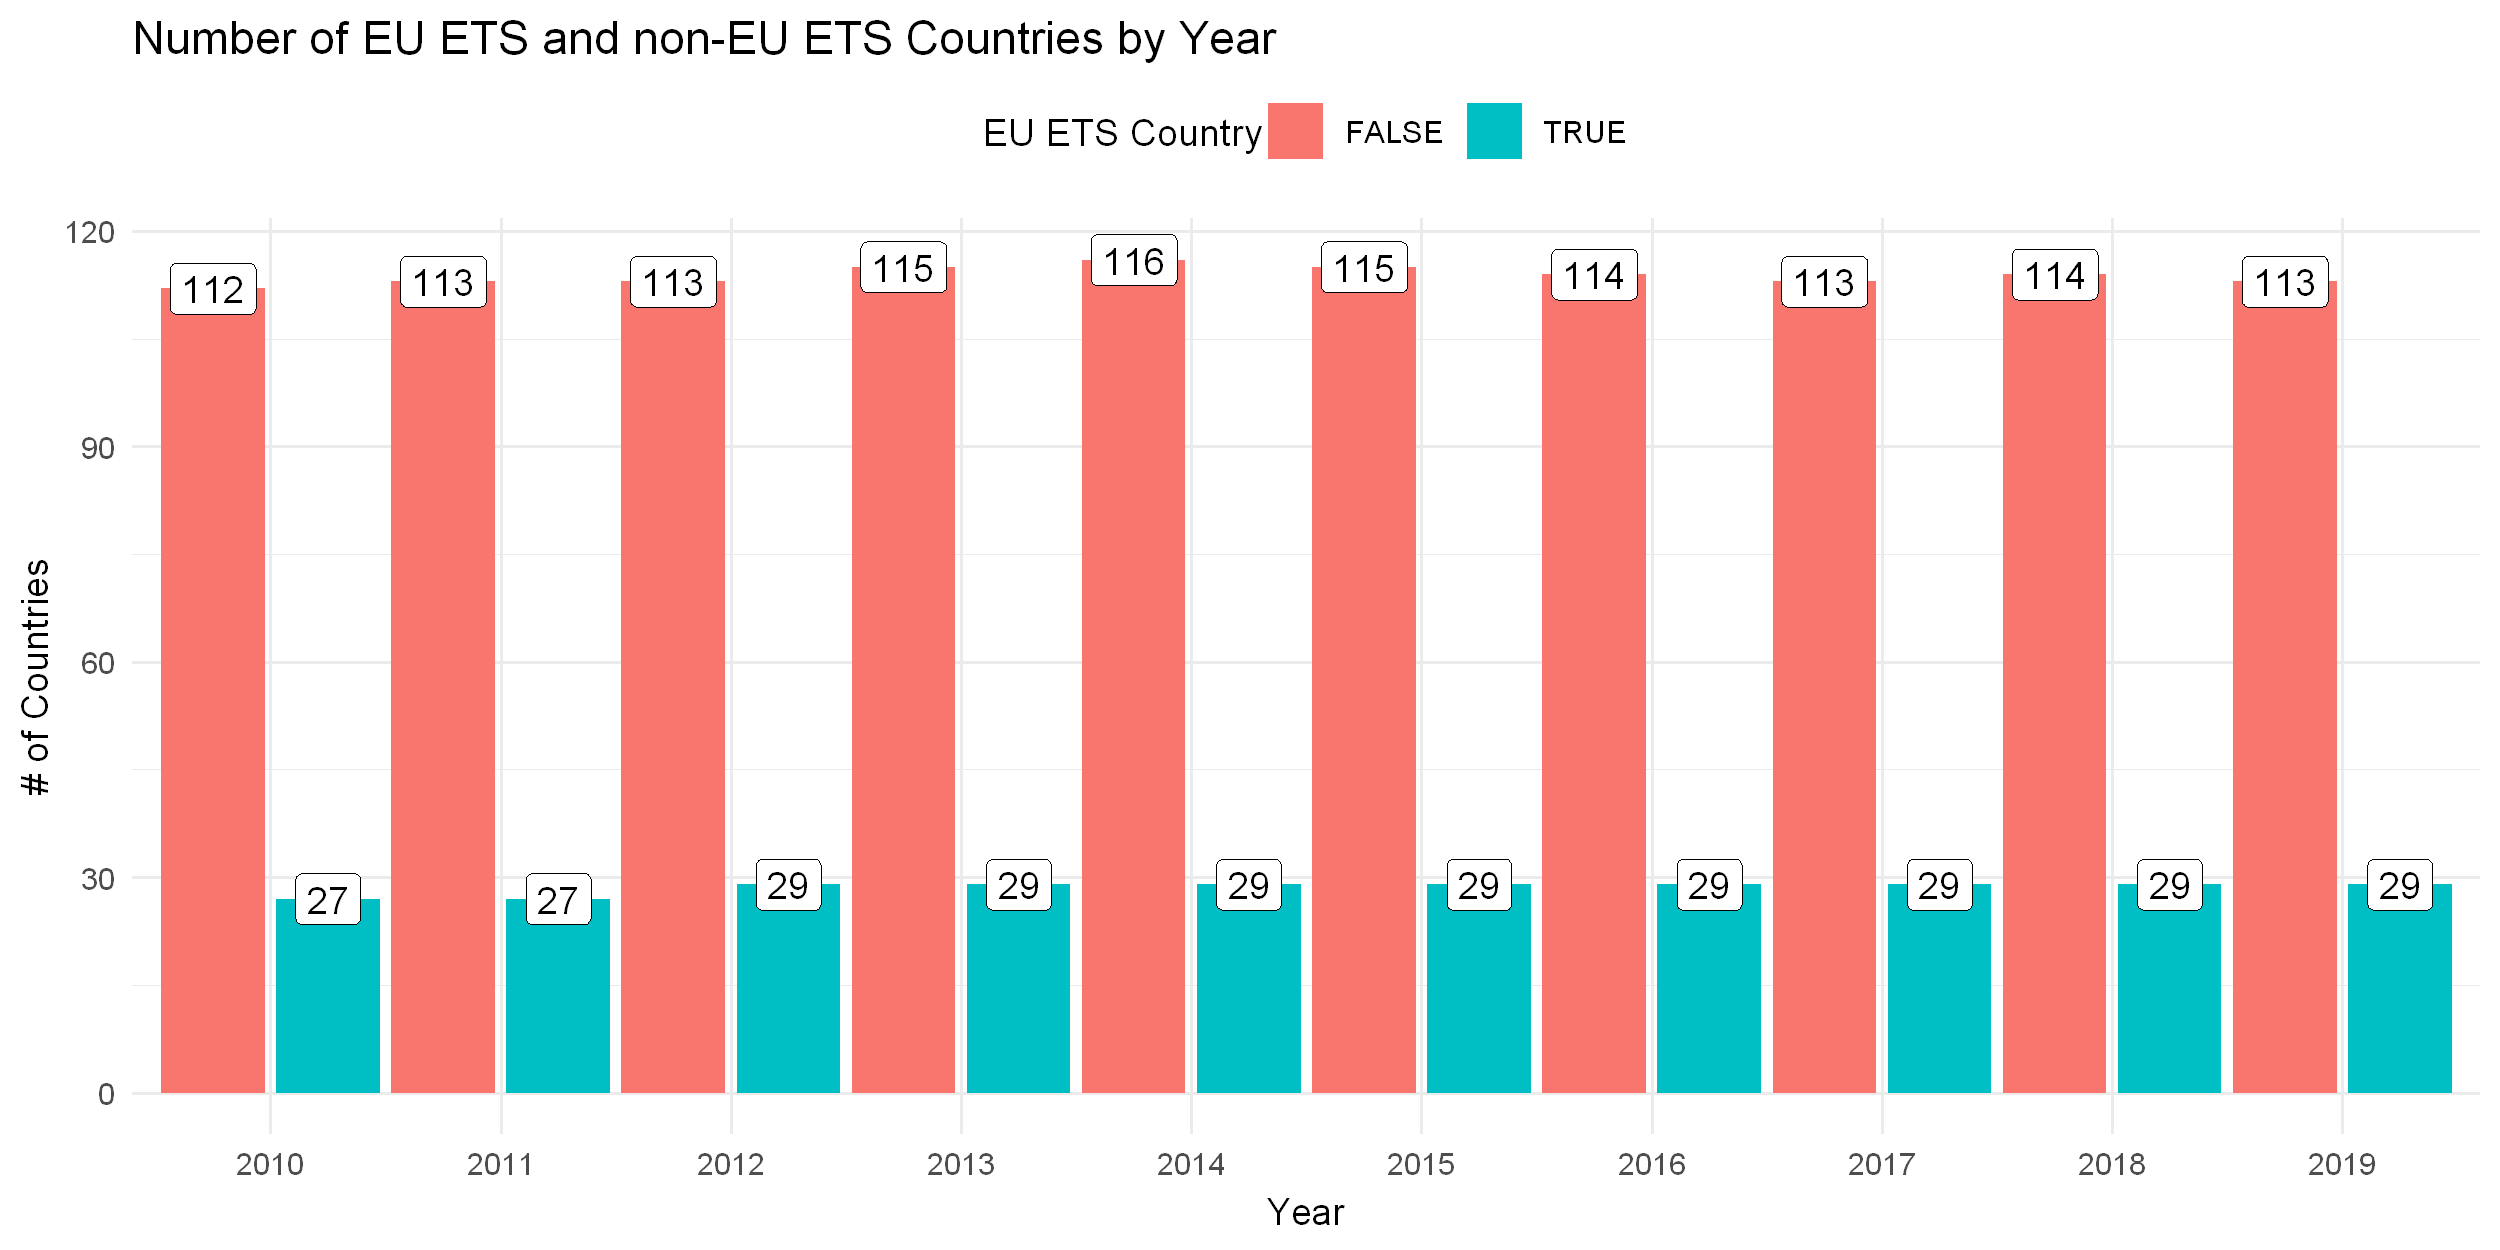

In [16]:
# Count of distinct countries for each year
year_country_breakdown <- all_indicators_final %>%
  group_by(year, is_eu_ets) %>%
  summarise(cnt = n(), .groups = 'drop')

ggplot(year_country_breakdown, aes(x=factor(year), y=cnt, group=is_eu_ets)) +
       geom_bar(aes(fill=is_eu_ets),position=position_dodge(width=1), stat="identity") + 
       geom_label(aes(label=cnt),position = position_dodge(width=1)) +
       labs(title = "Number of EU ETS and non-EU ETS Countries by Year",
          x = "Year",
          y = "# of Countries",
          fill = "EU ETS Country") +
        theme_minimal() + 
        theme(legend.position = "top")

# 3.Matching


Call:
matchit(formula = is_eu_ets ~ precipitation_log + humidity_log + 
    avg_surface_temp_log + gdp_per_capita_log + gdp_per_capita_growth_pct + 
    recession_binary + agriculture_pct_gdp + industry_pct_gdp + 
    pop_total_log + pop_in_largest_city_pct_of_urban_pop + pop_growth_pct + 
    pop_density_log + pop_urban_pct_of_total + pop_rural_pct_of_total, 
    data = all_indicators_final, method = "nearest", distance = "glm", 
    exact = "year", replace = FALSE, ratio = 1)

Summary of Balance for All Data:
                                     Means Treated Means Control
distance                                    0.8603        0.0351
precipitation_log                          -3.5730       -3.6194
humidity_log                                4.3168        4.1214
avg_surface_temp_log                        2.4006        3.0092
gdp_per_capita_log                         10.2967        8.1966
gdp_per_capita_growth_pct                   1.8729        1.9467
recession_binary           

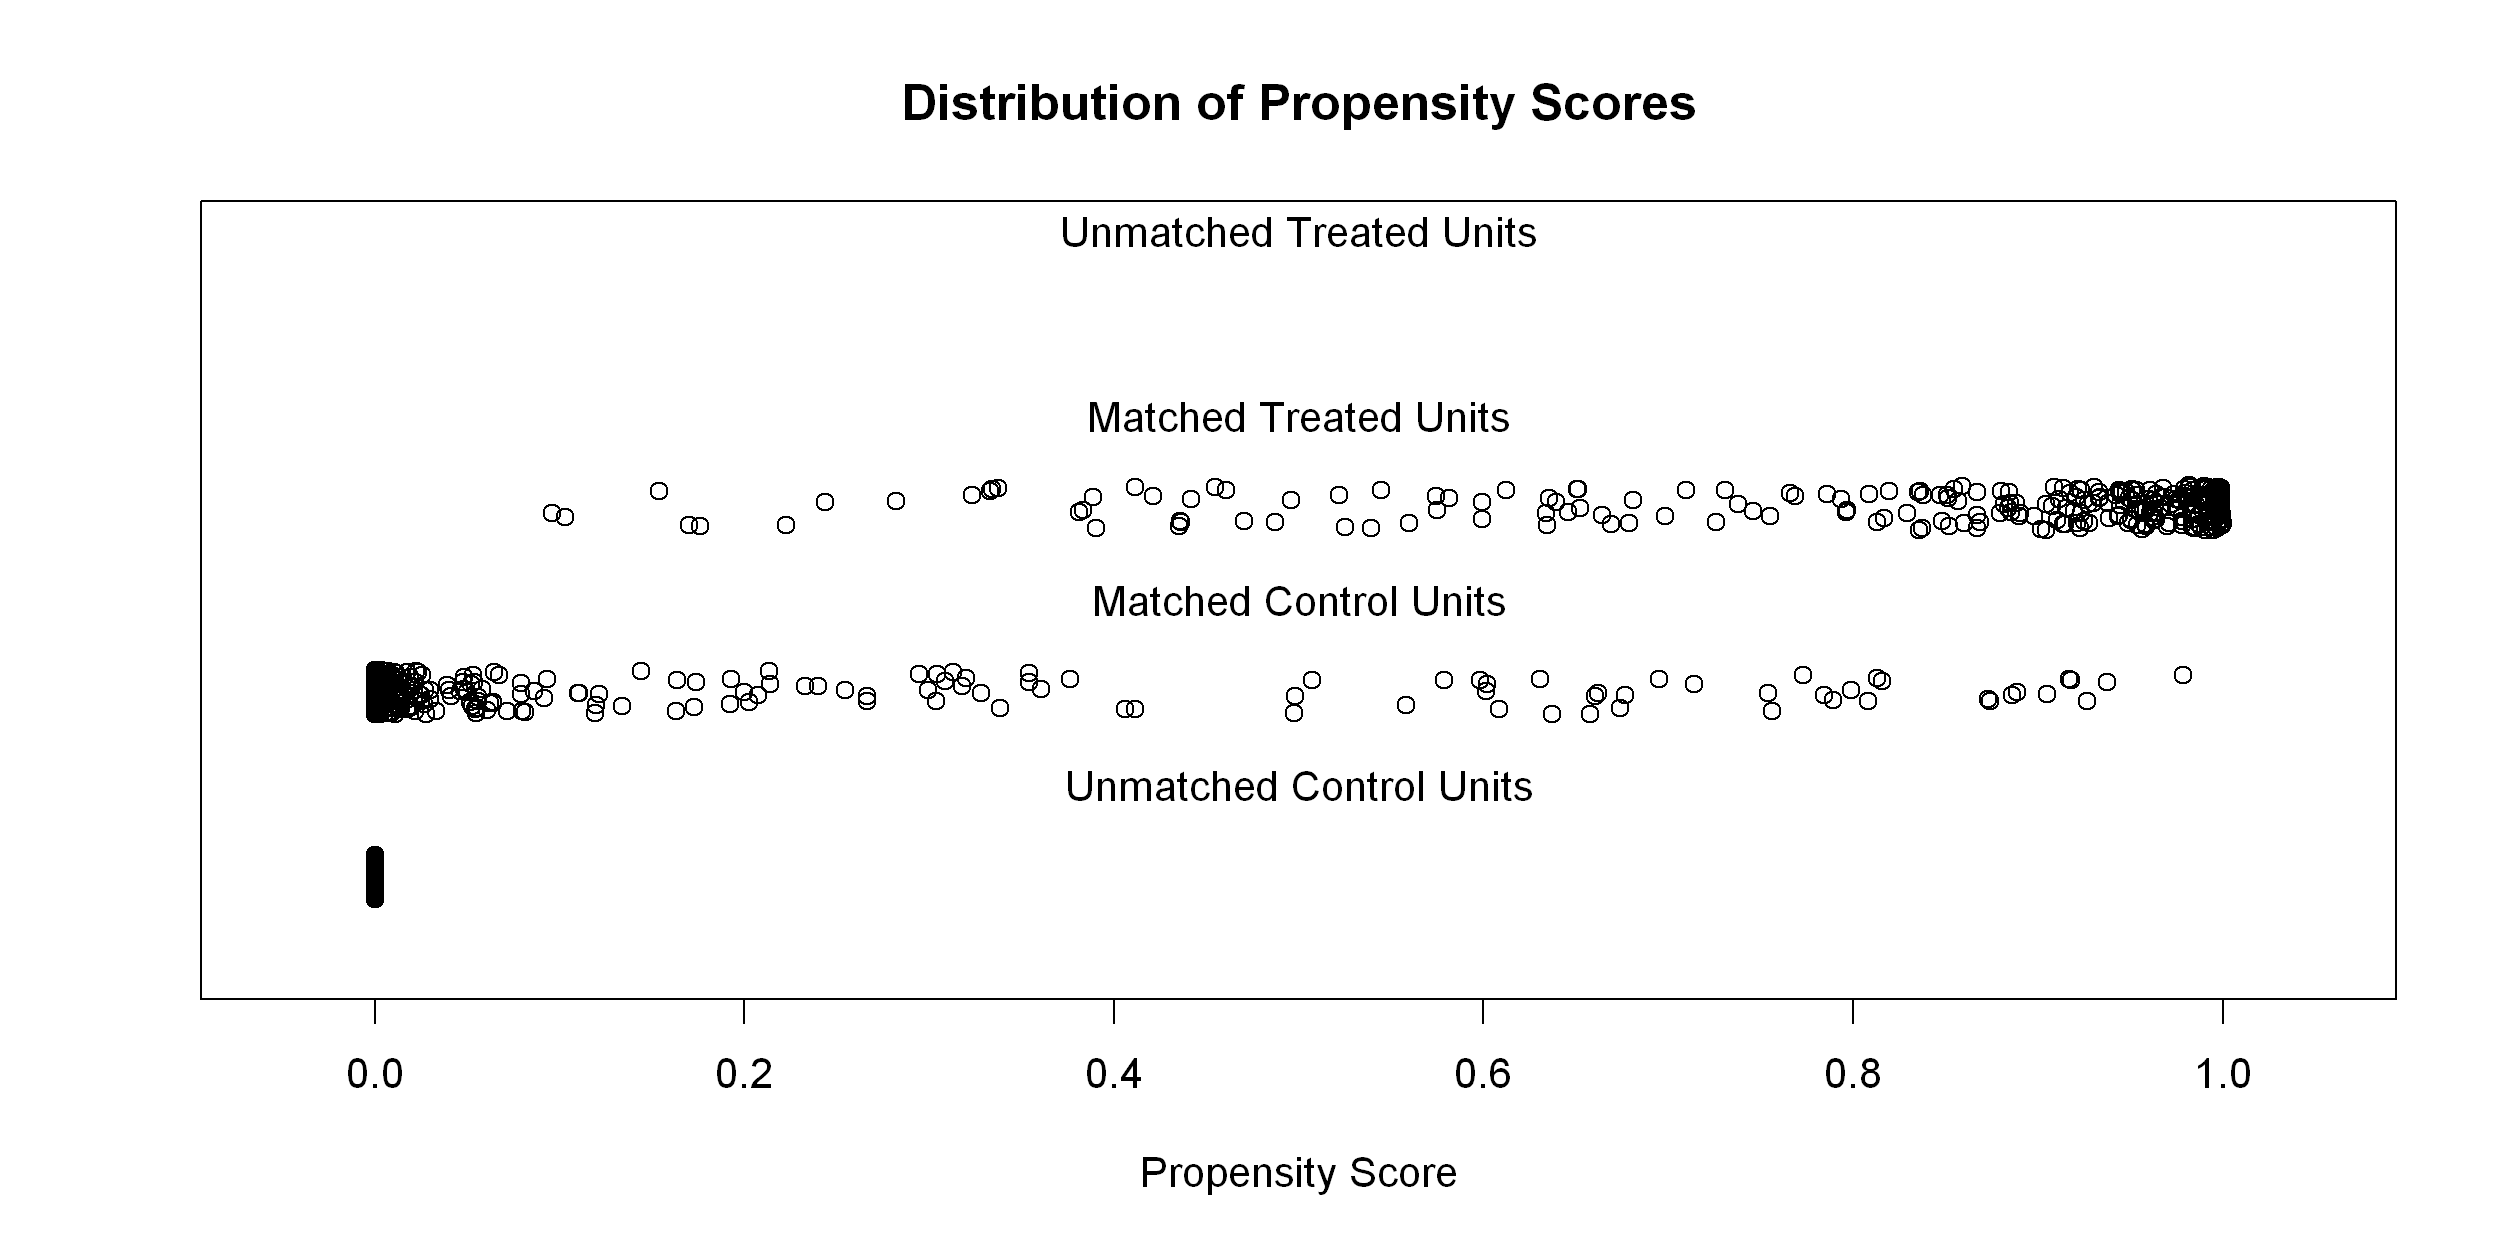

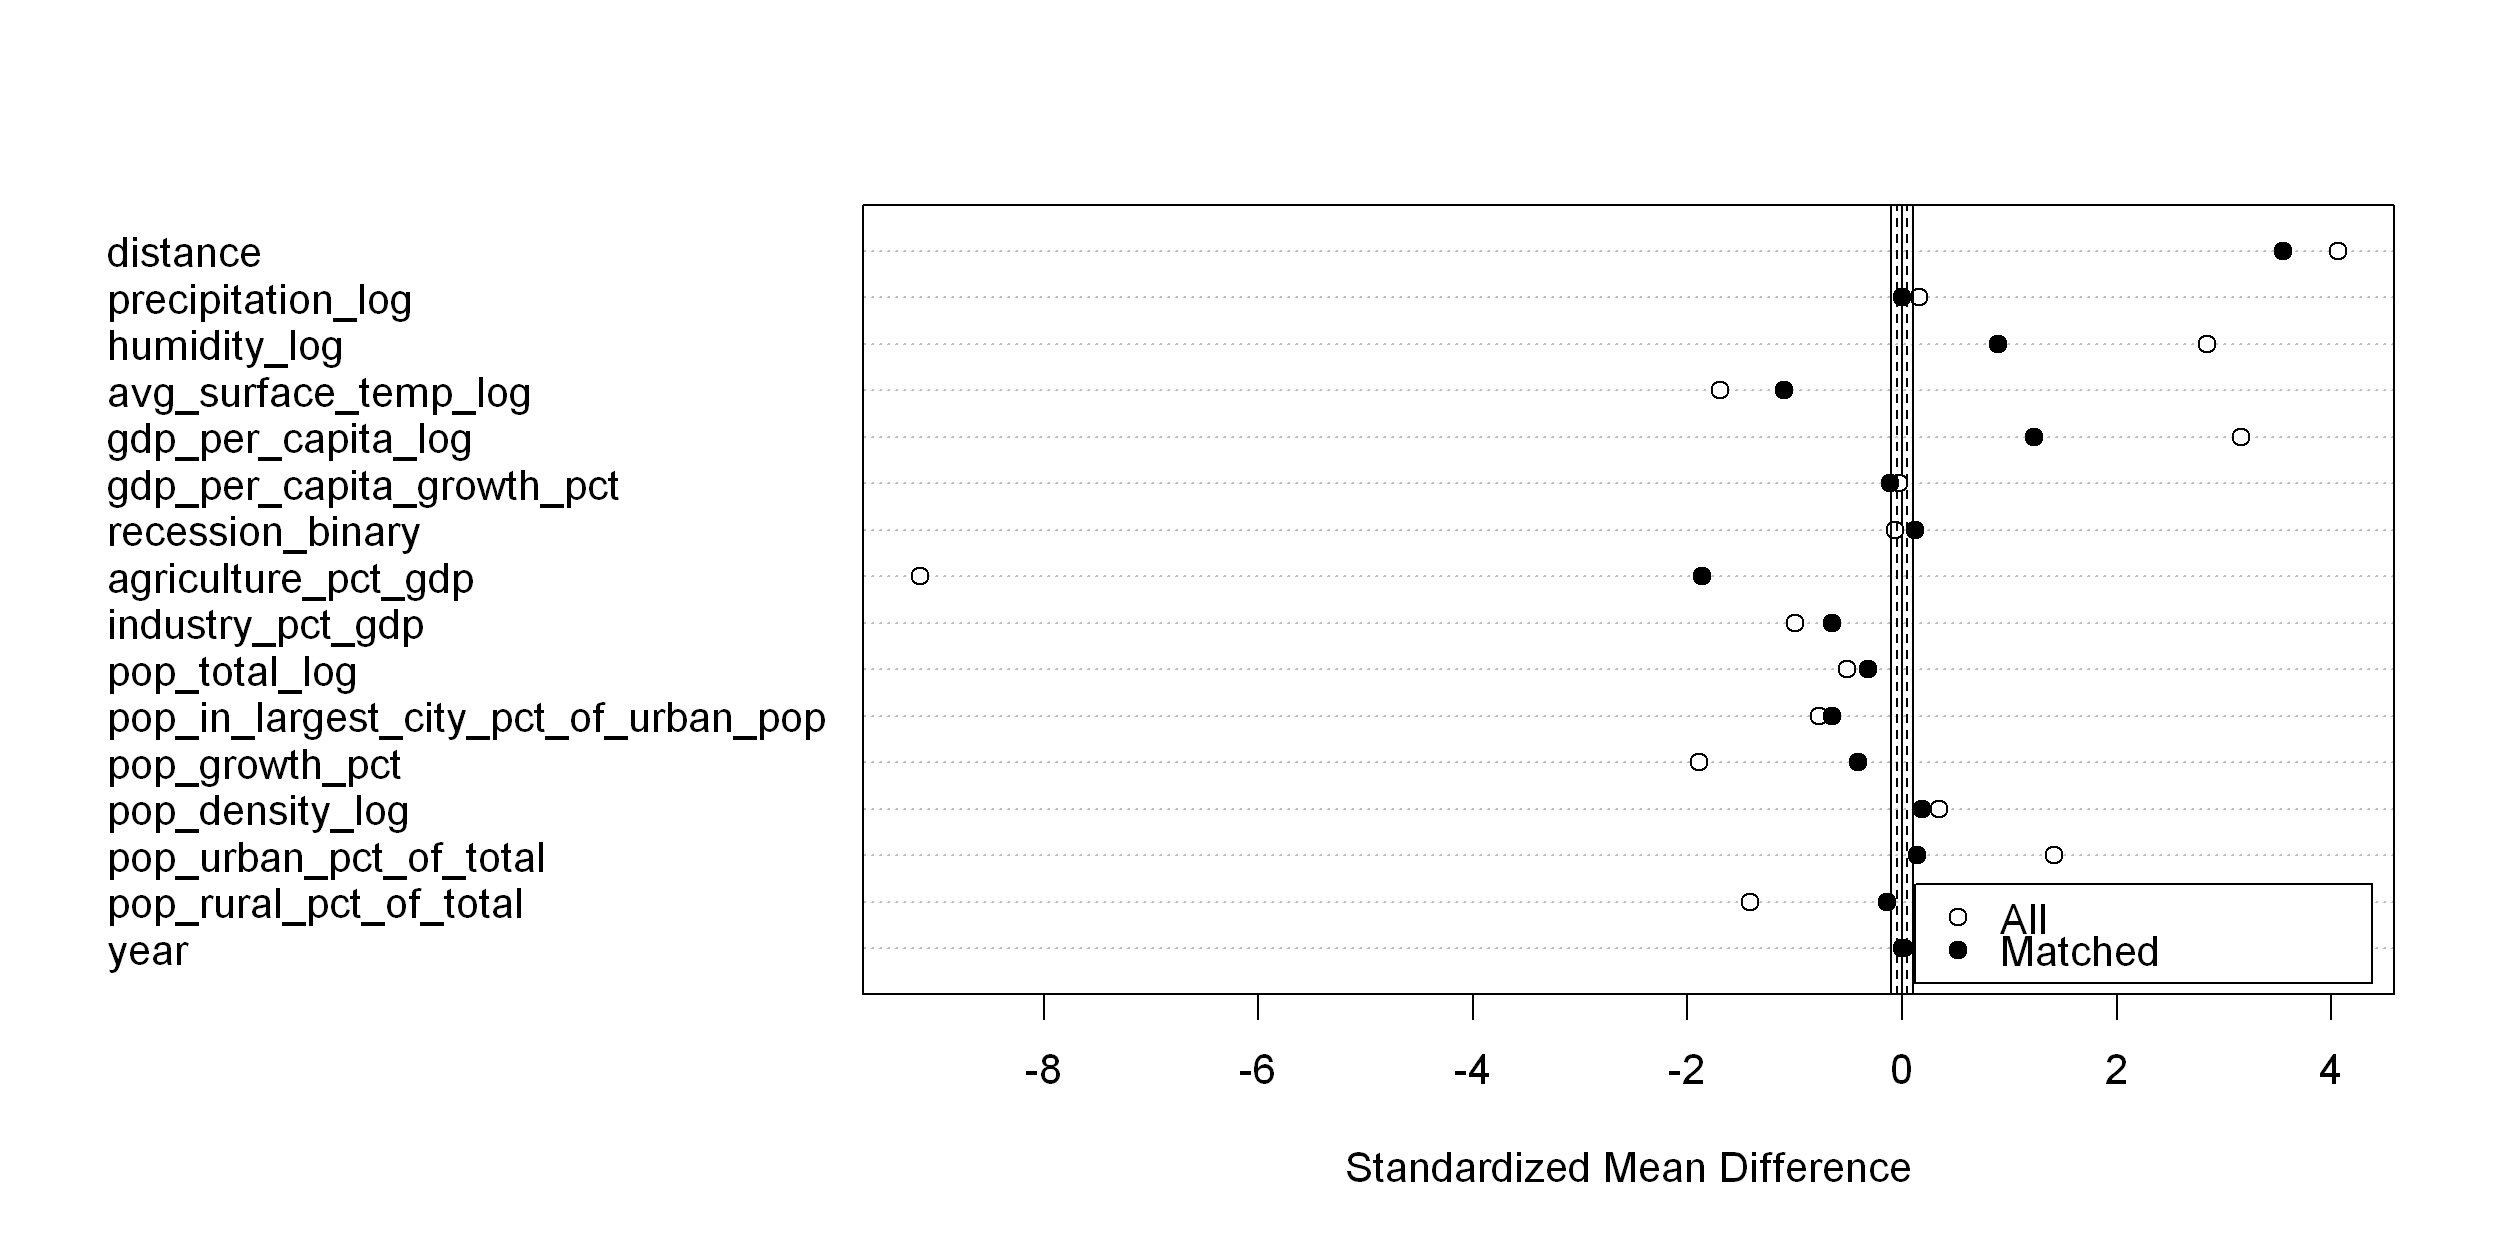

In [17]:
match_obj <- matchit(is_eu_ets ~ 
                      precipitation_log 
                      + humidity_log
                      + avg_surface_temp_log 
                      + gdp_per_capita_log 
                      + gdp_per_capita_growth_pct
                      + recession_binary
                      + agriculture_pct_gdp
                      + industry_pct_gdp 
                      + pop_total_log 
                      + pop_in_largest_city_pct_of_urban_pop 
                      + pop_growth_pct
                      + pop_density_log 
                      + pop_urban_pct_of_total 
                      + pop_rural_pct_of_total
  ,data = all_indicators_final, method = "nearest"
  ,distance ="glm"
  ,ratio = 1
  ,replace = FALSE
  ,exact = "year"
  )

matched_subset <- data.frame(match.data(match_obj))

summary(match_obj)
plot(match_obj, type = "jitter", interactive = FALSE)
plot(summary(match_obj), abs = FALSE)

In [18]:
unique(matched_subset[matched_subset$is_eu_ets == FALSE,"country"])
matched_subset[(matched_subset$subclass %in% matched_subset[matched_subset$country == "Germany","subclass"]),]%>% arrange (year,is_eu_ets)

[1] "Australia"              "Belarus"                "Bosnia and Herzegovina"
 [4] "Brazil"                 "Canada"                 "Costa Rica"            
 [7] "Croatia"                "Cuba"                   "Dominican Republic"    
[10] "Georgia"                "Israel"                 "Jamaica"               
[13] "Japan"                  "Lebanon"                "Moldova"               
[16] "New Zealand"            "Panama"                 "Russian Federation"    
[19] "Serbia"                 "South Africa"           "Sri Lanka"             
[22] "Switzerland"            "Trinidad and Tobago"    "Ukraine"               
[25] "United States"          "Uruguay"                "Venezuela"             
[28] "Bahrain"                "Kazakhstan"             "United Arab Emirates"  
[31] "Colombia"               "Thailand"               "El Salvador"           
[34] "Djibouti"               "Syria"                  "Ecuador"               
[37] "Mexico"                 "Qatar"                  "Oman"

country,year,country_code,PM25_Cities_log,PM25_rural_log,PM25_Total_log,PM25_Towns_log,PM25_Urban_log,precipitation_log,humidity_log,⋯,pop_growth_pct,pop_urban_pct_of_total,pop_rural_pct_of_total,pop_in_largest_city_pct_of_urban_pop,is_eu_ets,free_EUAs_log,auctioned_sold_EUAs_log,distance,weights,subclass
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Australia,2010,AUS,2.228939,2.069391,2.200552,2.213754,2.223542,-3.575551,4.126328,⋯,1.5557063,85.182,14.818,22.197049,FALSE,0.00000,0.00000,0.133700852,1,167
Germany,2010,DEU,2.826129,2.599722,2.712042,2.698673,2.756840,-3.473768,4.346788,⋯,-0.1531984,76.966,23.034,5.482001,TRUE,19.80581,17.53255,0.994969399,1,167
Bahrain,2011,BHR,3.997834,3.989539,4.001681,4.085136,4.002229,-5.809143,4.210200,⋯,-0.1292811,88.695,11.305,29.509177,FALSE,0.00000,0.00000,0.978730758,1,107
Germany,2011,DEU,2.850128,2.624669,2.735665,2.720637,2.779440,-3.688879,4.323338,⋯,-1.8537146,77.160,22.840,5.590788,TRUE,19.80651,17.52114,0.999983423,1,107
United States,2012,USA,2.277267,2.065596,2.204972,2.180417,2.244956,-3.575551,4.093678,⋯,0.7335999,81.119,18.881,7.257157,FALSE,0.00000,0.00000,0.173699886,1,137
Germany,2012,DEU,2.734368,2.512035,2.621766,2.606387,2.665143,-3.575551,4.339510,⋯,0.1877278,77.170,22.830,5.599898,TRUE,19.93973,17.73962,0.983412673,1,137
Brazil,2013,BRA,2.654649,2.432736,2.576422,2.486572,2.607861,-3.036554,4.282621,⋯,0.8683462,85.209,14.791,11.860574,FALSE,0.00000,0.00000,0.019466661,1,171
Germany,2013,DEU,2.698000,2.476538,2.585506,2.570320,2.628285,-3.575551,4.357606,⋯,0.2729002,77.180,22.820,5.604192,TRUE,18.97956,19.14383,0.988731183,1,171
Brazil,2014,BRA,2.665143,2.441477,2.587012,2.497329,2.618125,-3.101093,4.278886,⋯,0.8578348,85.492,14.508,11.862196,FALSE,0.00000,0.00000,0.109989059,1,204


### 3.a. Target variables' trend in matched samples

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


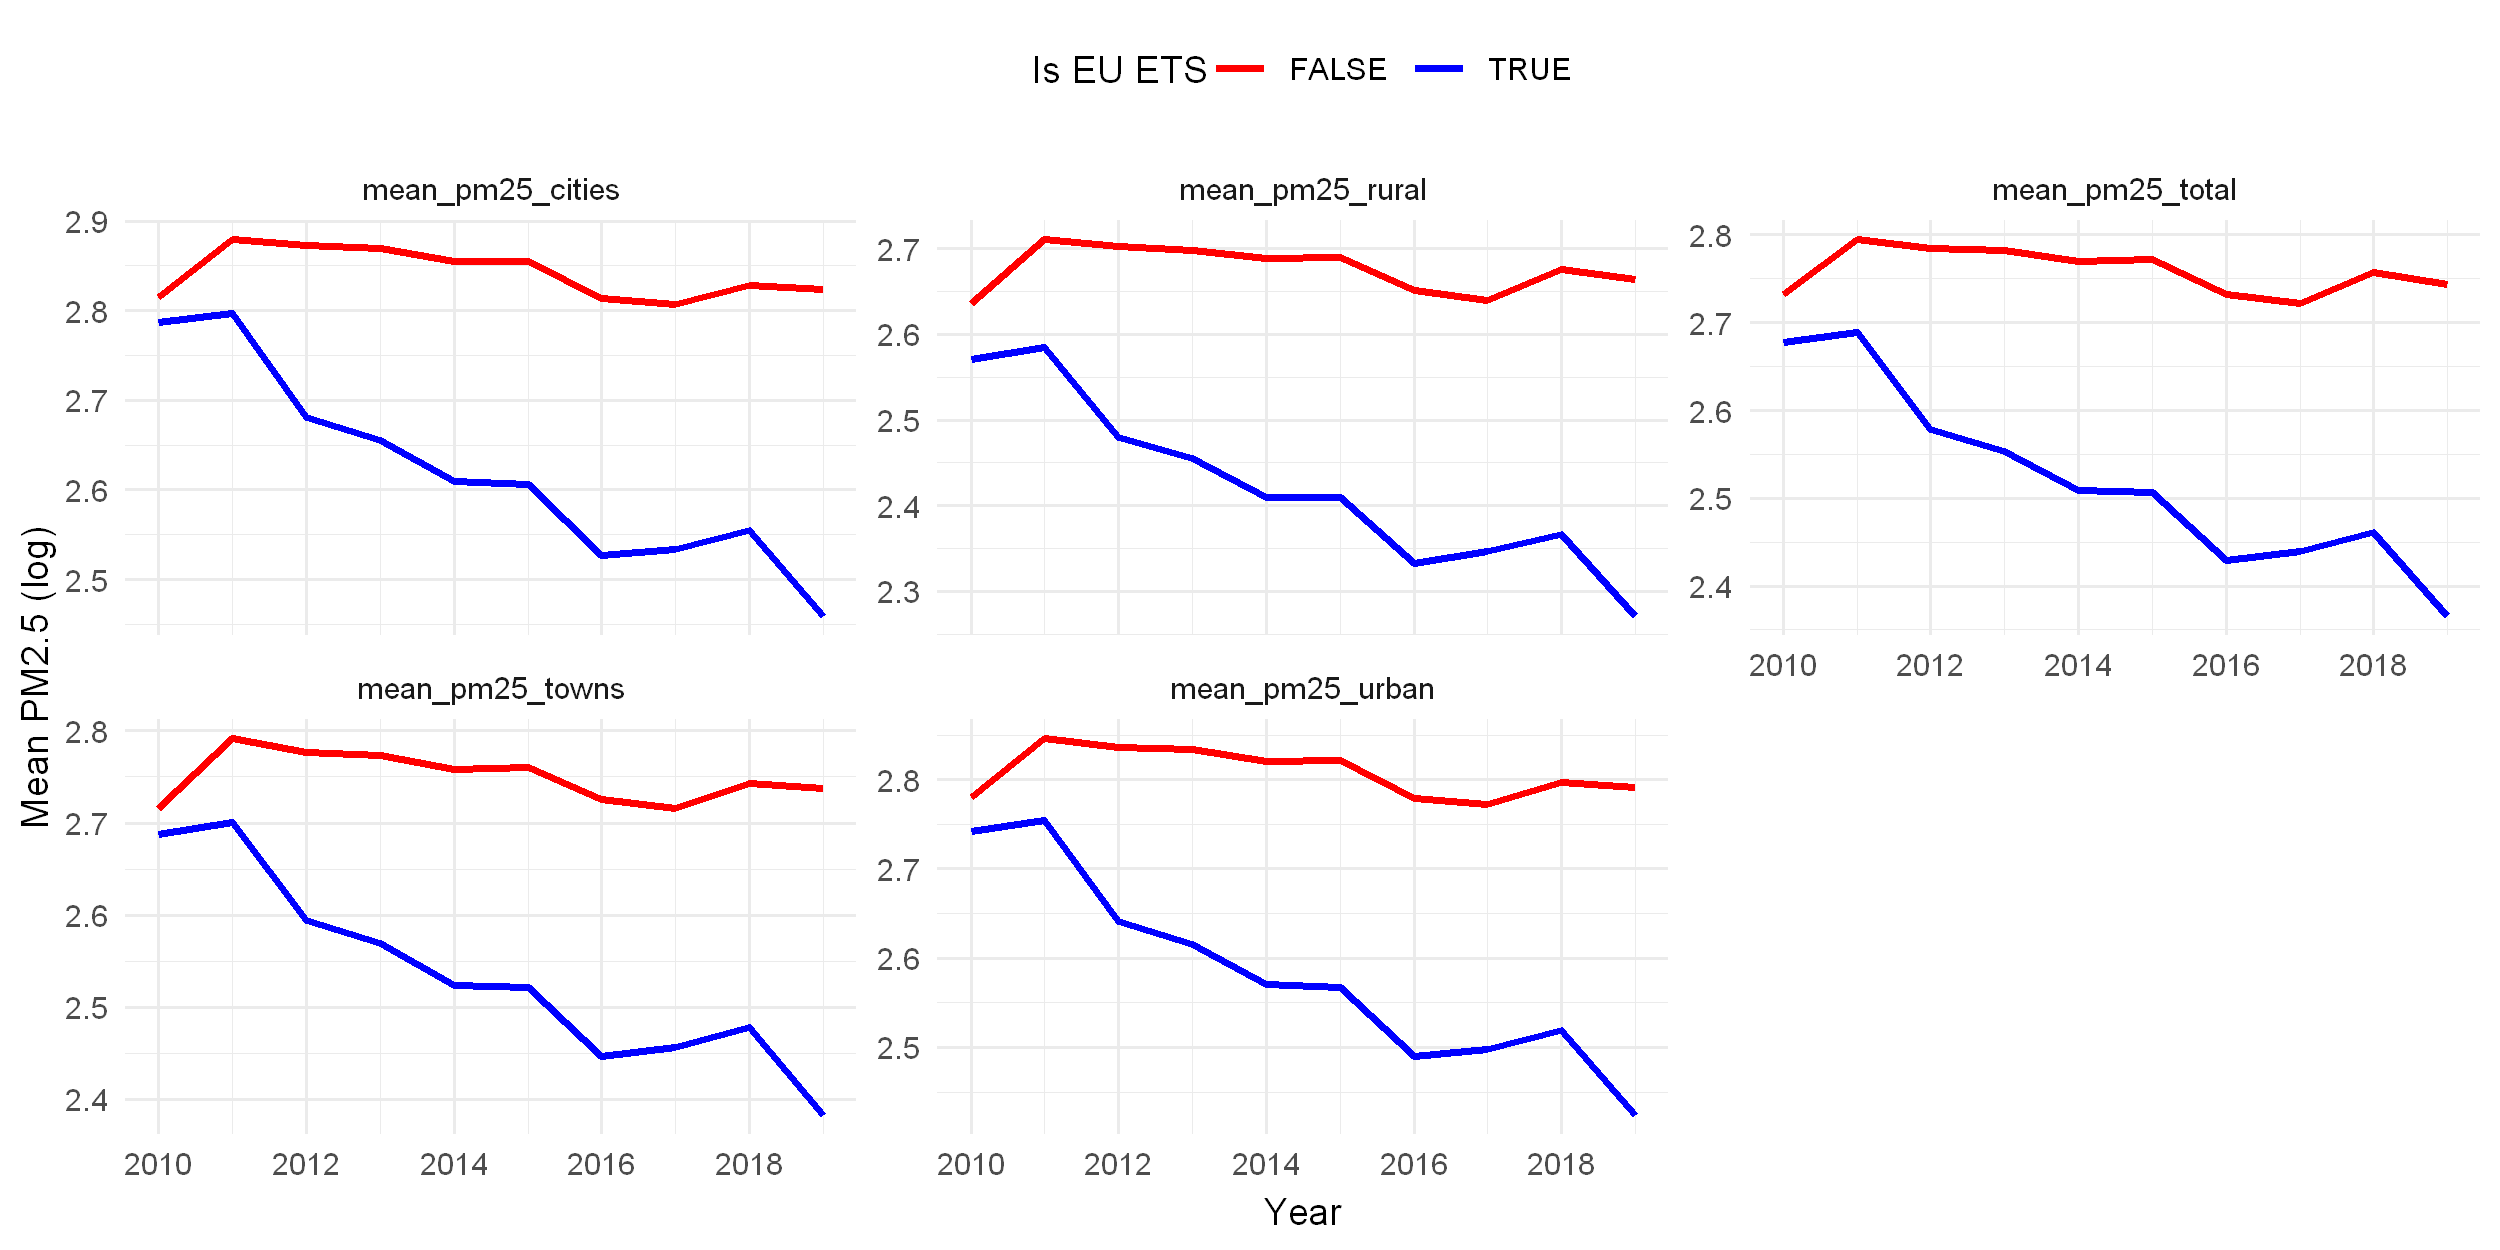

In [19]:
mean_pm25_of_groups <- matched_subset %>%
  group_by(year, is_eu_ets) %>%
  summarise(mean_pm25_total = mean(PM25_Total_log),
    mean_pm25_cities = mean(PM25_Cities_log),
    mean_pm25_rural = mean(PM25_rural_log),
    mean_pm25_towns = mean(PM25_Towns_log),
    mean_pm25_urban = mean(PM25_Urban_log),
    .groups = "drop") %>%
    pivot_longer(cols = starts_with("mean_pm25_"),
               names_to = "pm25_type",
               values_to = "mean_pm25")

# Plotting with customized aesthetics
ggplot(mean_pm25_of_groups, aes(x = year, y = mean_pm25, color = as.factor(is_eu_ets))) +
  geom_line(size = 1) +  # Increase line thickness
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +  # Assign colors
  facet_wrap(~pm25_type, scales = "free_y") +
  labs(x = "Year", y = "Mean PM2.5 (log)", color = "Is EU ETS") +
  theme_minimal() +
  guides(color = guide_legend(title = "Is EU ETS")) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +  # Adjust X axis labels
  theme(legend.position = "top")

### 3.a. Distributions and differences of matched samples

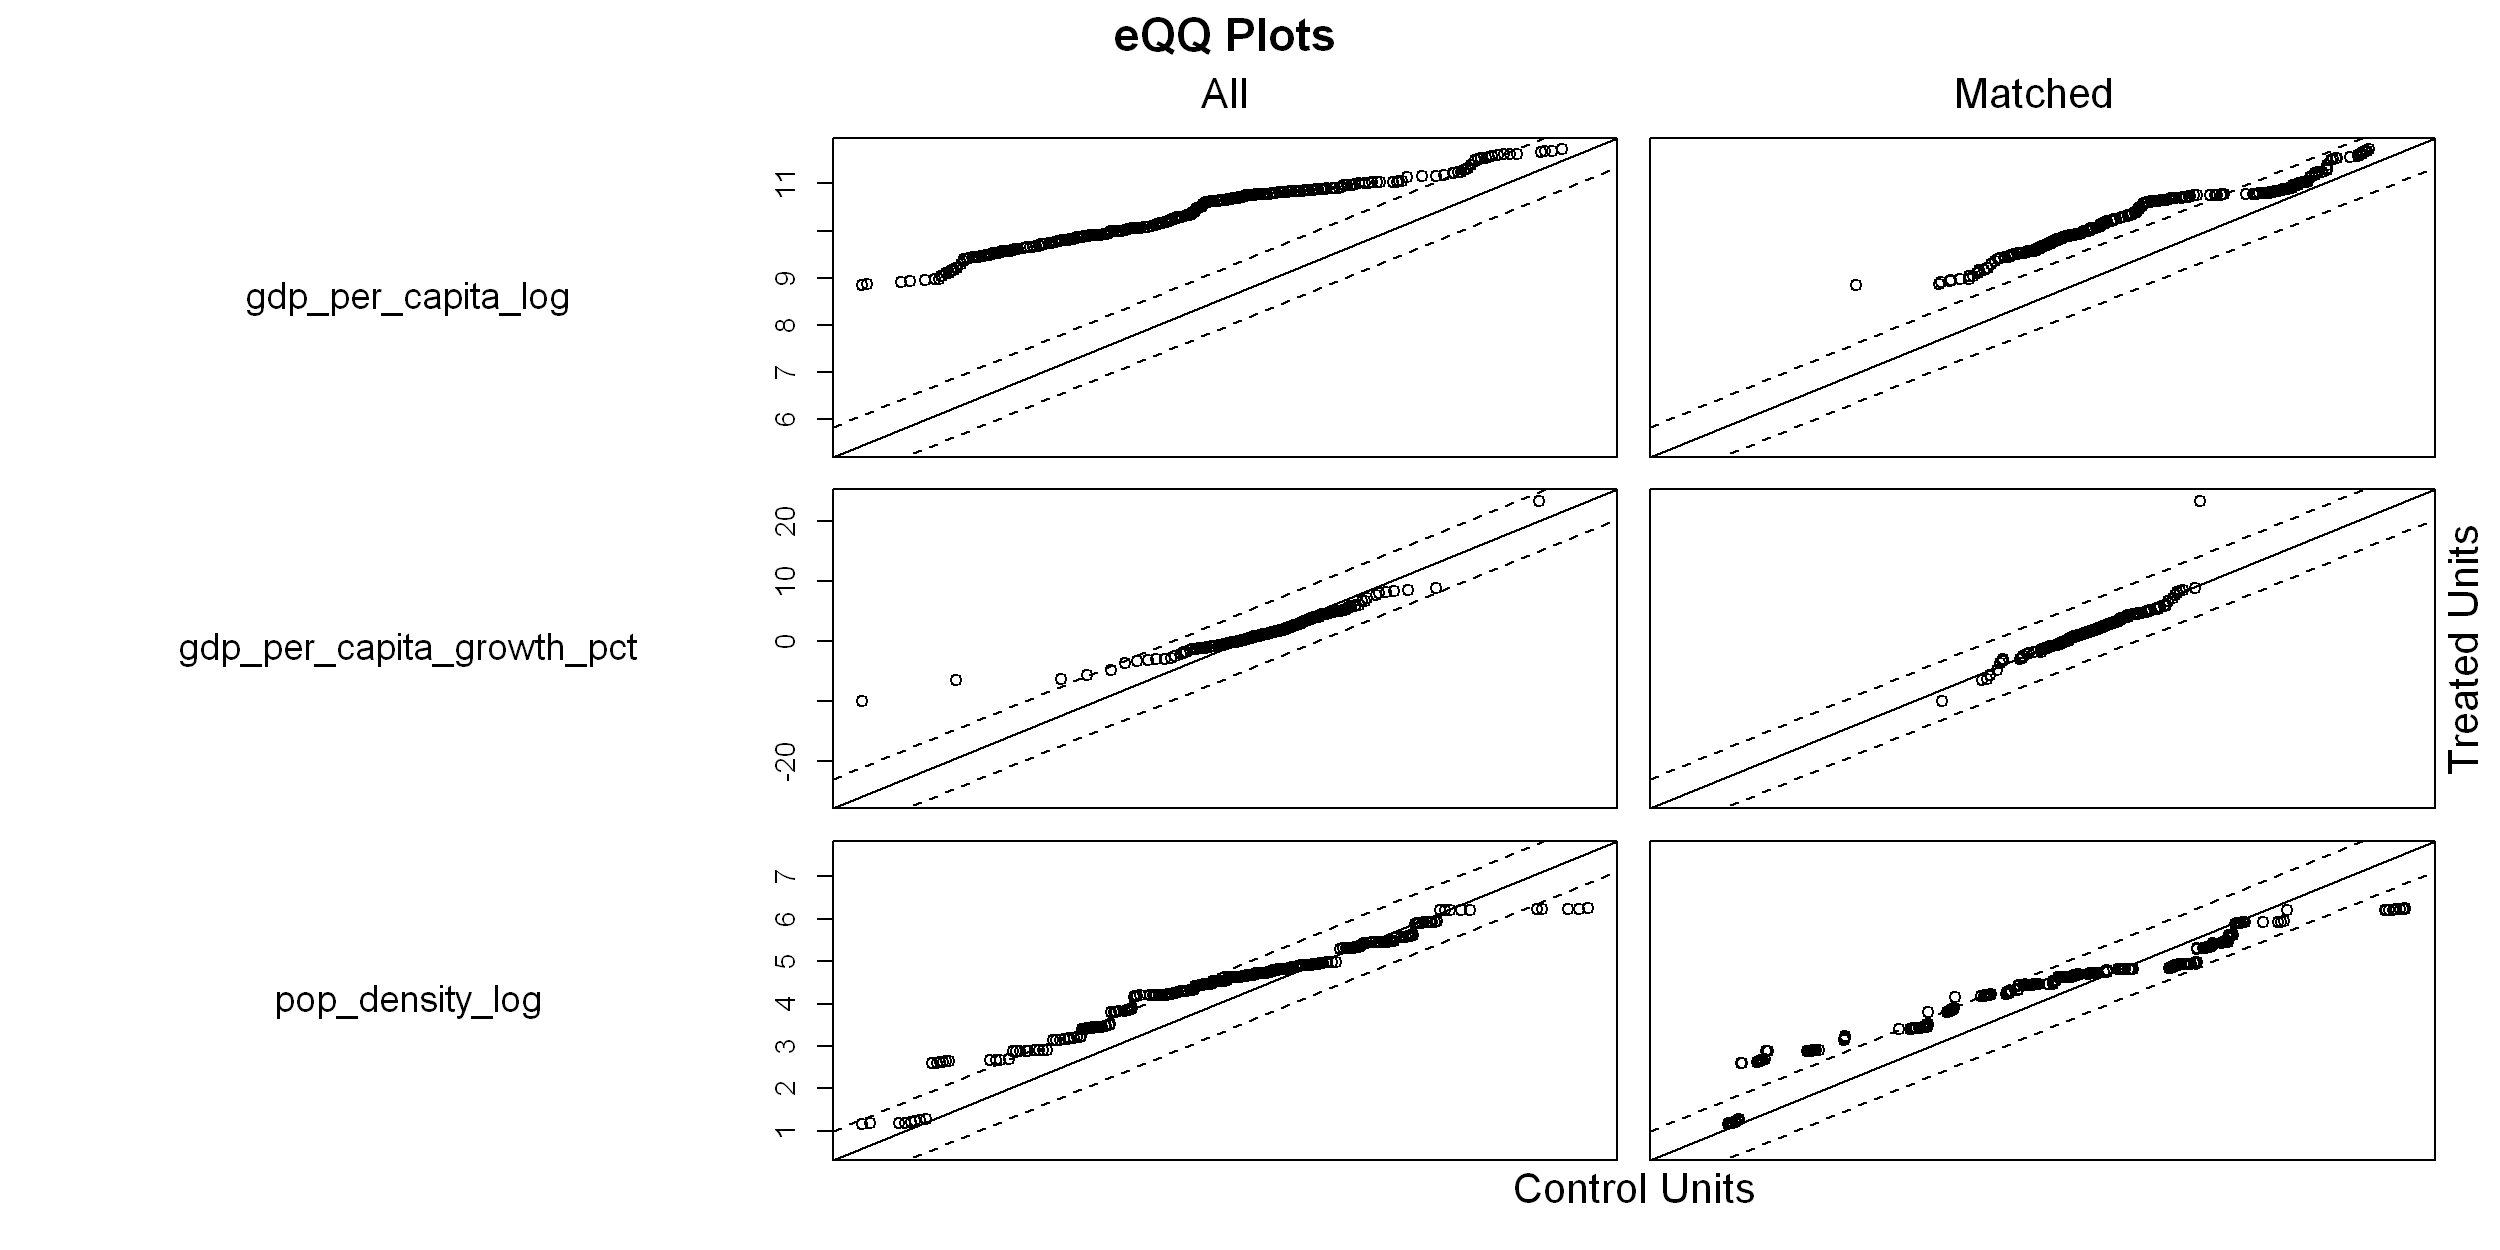

In [20]:
plot(match_obj, type = "qq", which.xs = ~gdp_per_capita_log +gdp_per_capita_growth_pct + pop_density_log)

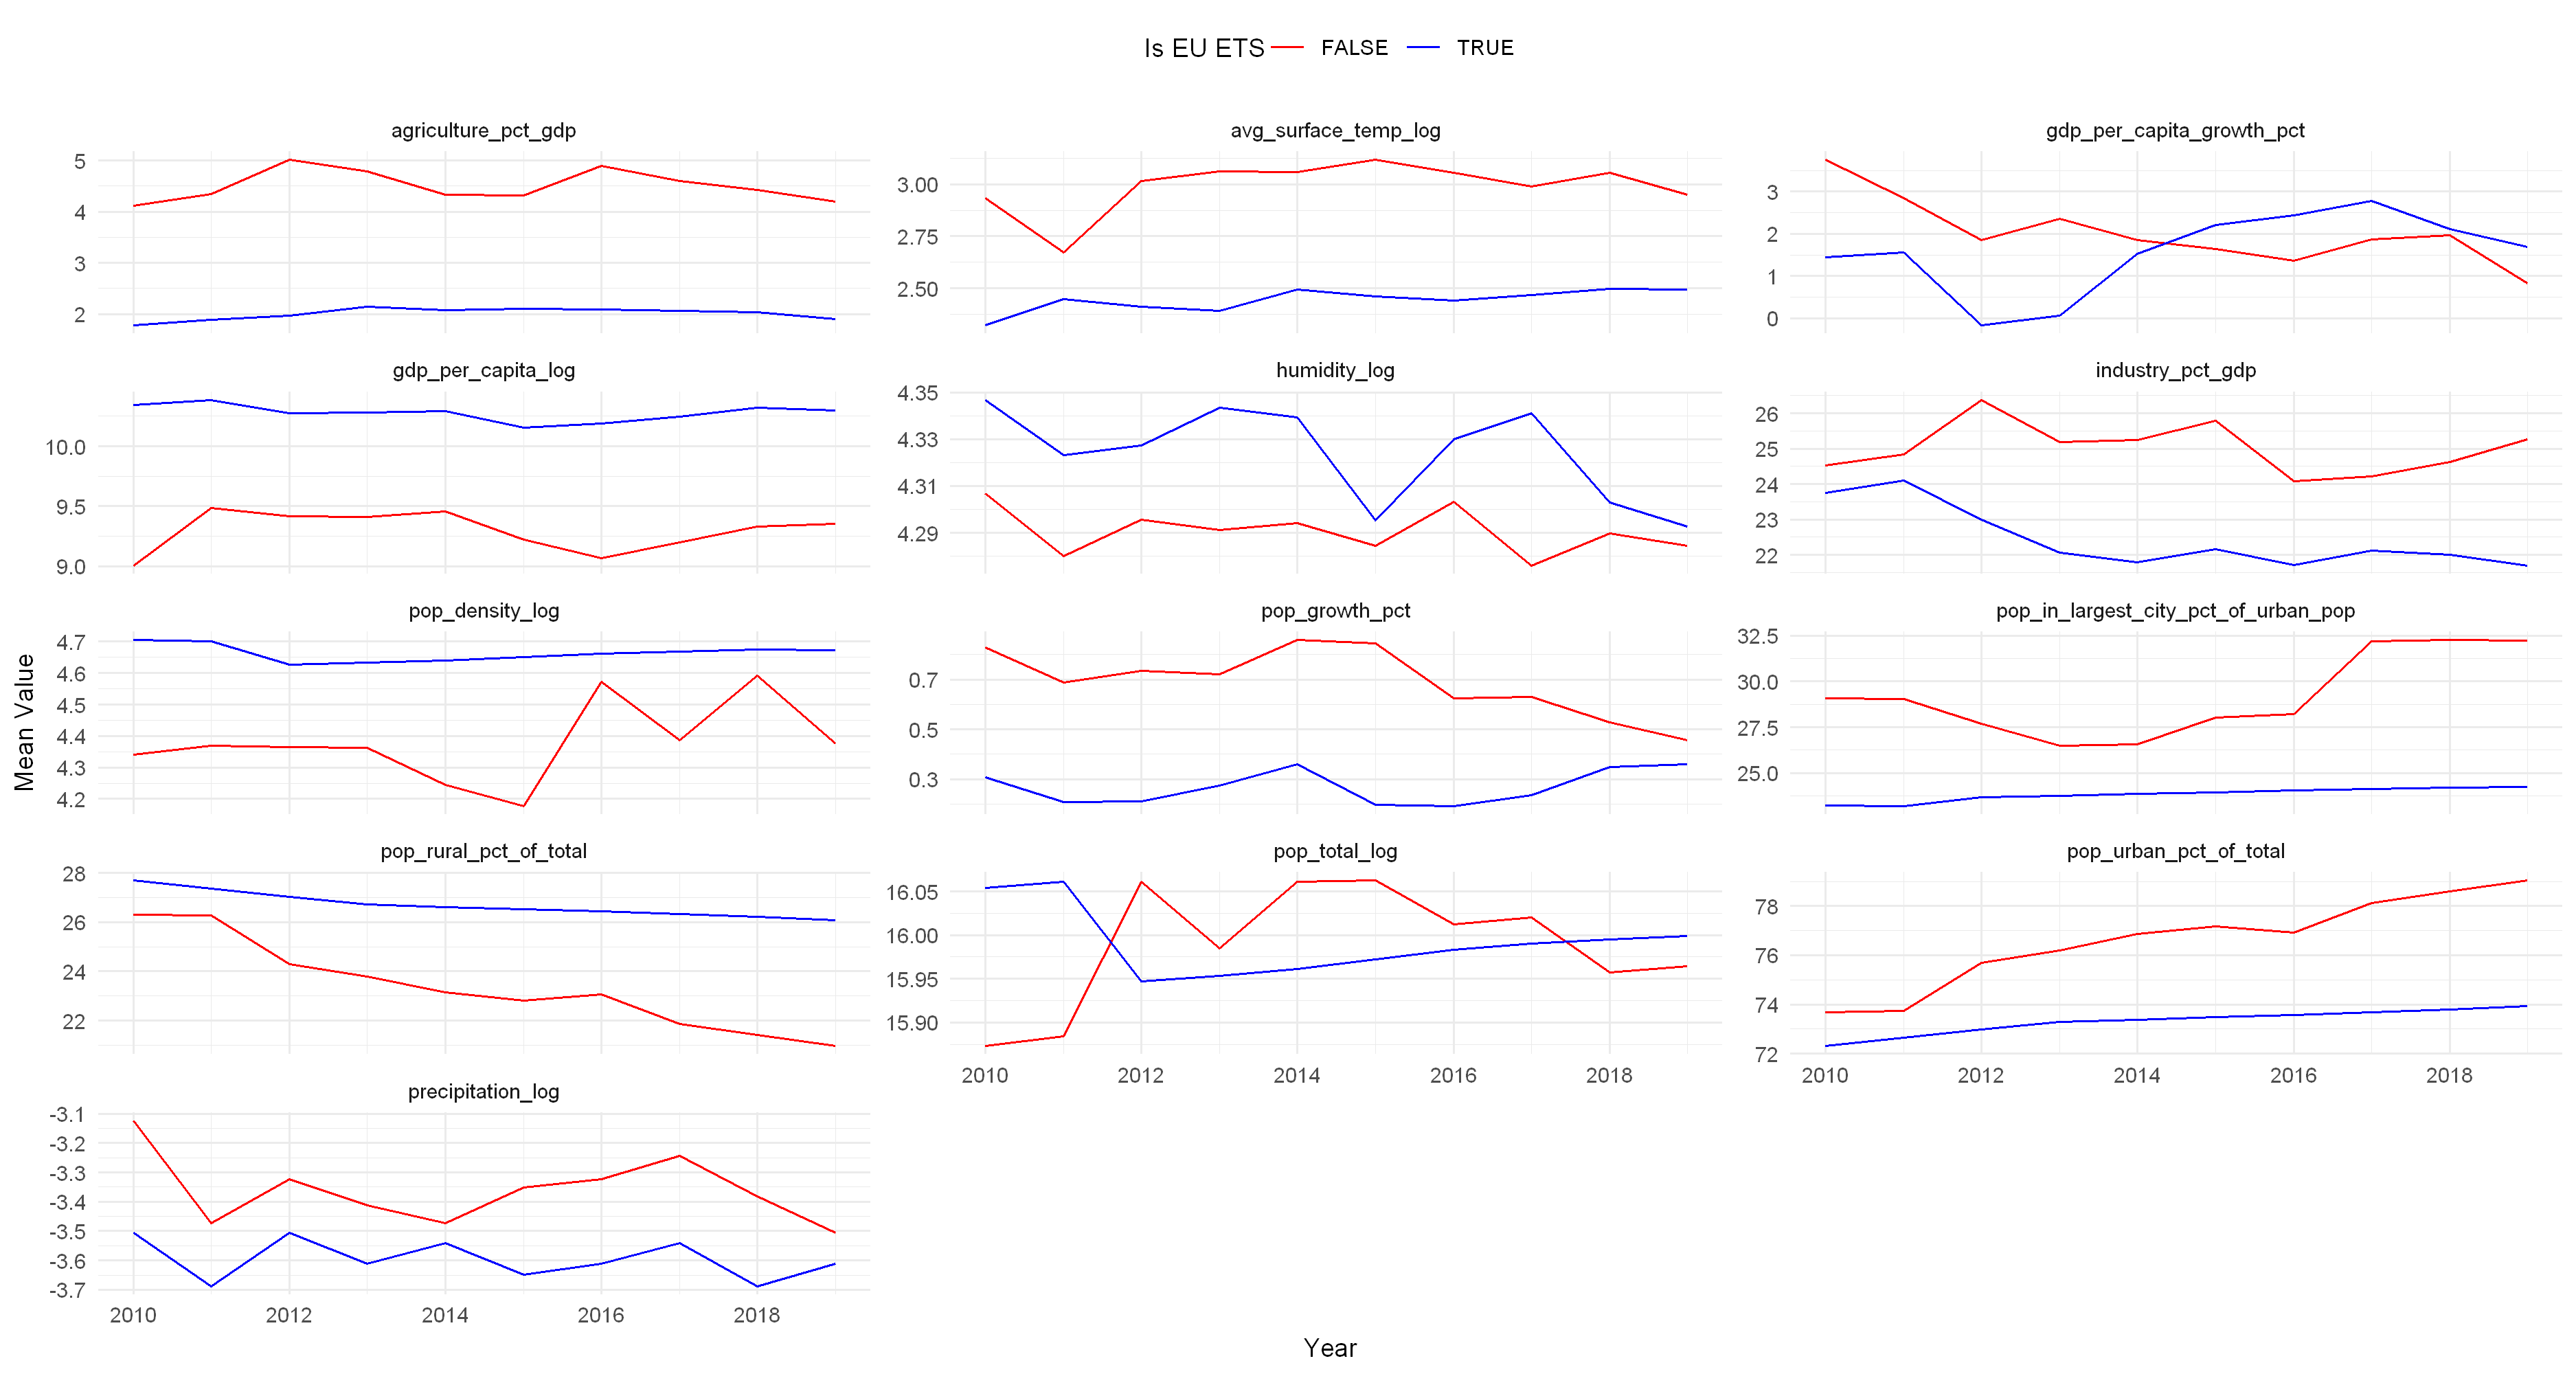

In [21]:
mean_of_all_columns <- matched_subset %>%
  select(-country, -country_code, -distance, -weights, -subclass, 
  -PM25_Cities_log, -PM25_rural_log, -PM25_Towns_log, -PM25_Urban_log, -PM25_Total_log, 
  -free_EUAs_log, -auctioned_sold_EUAs_log, -recession_binary) %>%
  group_by(year, is_eu_ets) %>%
  summarise_all(median, na.rm = TRUE) %>%
  pivot_longer(cols = -c(year, is_eu_ets), names_to = "variable", values_to = "value")

options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 250)

ggplot(mean_of_all_columns, aes(x = year, y = value, color = as.factor(is_eu_ets))) +
  geom_line(size = 0.5) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +
  labs(x = "Year", y = "Mean Value", color = "Is EU ETS") +
  theme_minimal() +
  guides(color = guide_legend(title = "Is EU ETS")) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  facet_wrap(~ variable, scales = "free_y", ncol = 3) +
  theme(legend.position = "top")

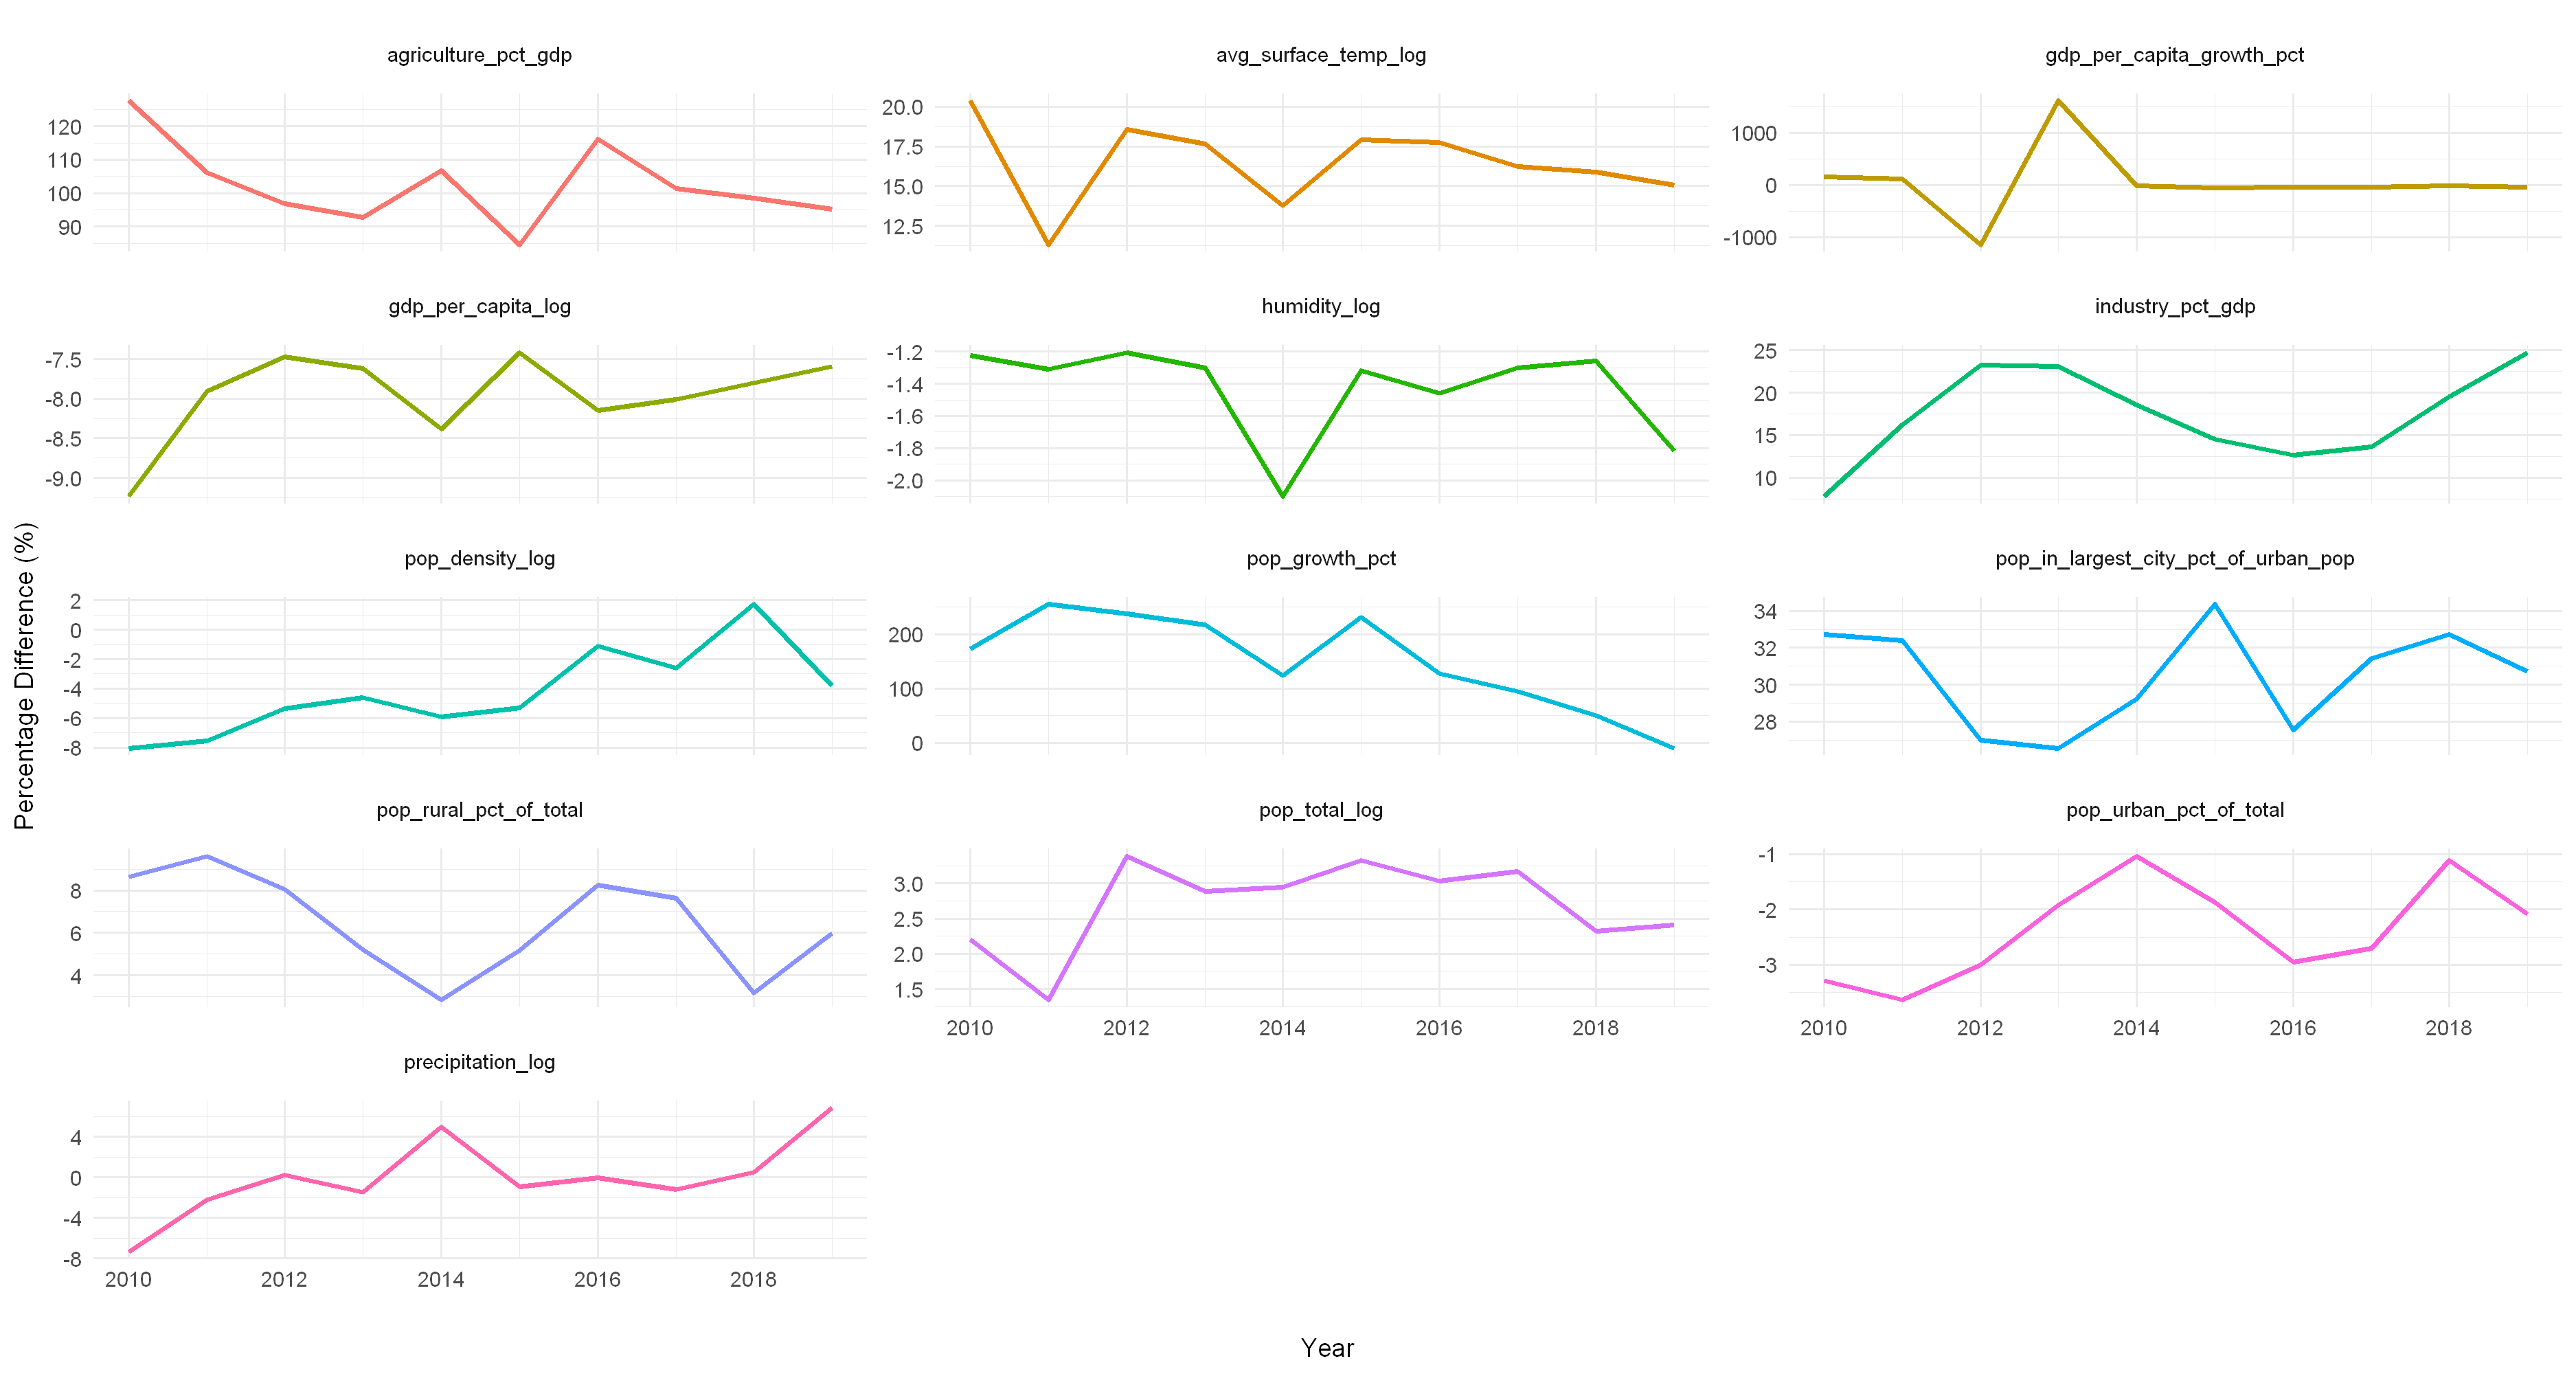

In [22]:
mean_of_all_columns <- matched_subset %>%
  select(-country, -country_code, -distance, -weights, -subclass, 
         -PM25_Cities_log, -PM25_rural_log, -PM25_Towns_log, -PM25_Urban_log, -PM25_Total_log, 
         -free_EUAs_log, -auctioned_sold_EUAs_log, -recession_binary) %>%
  group_by(year, is_eu_ets) %>%
  summarise_all(mean, na.rm = TRUE) %>%
  pivot_longer(cols = -c(year, is_eu_ets), names_to = "variable", values_to = "value")

# Calculate percentage difference for each variable
mean_of_all_columns <- mean_of_all_columns %>%
  group_by(variable, year) %>%
  mutate(pct_diff = (value[is_eu_ets == FALSE] - value[is_eu_ets == TRUE]) / value[is_eu_ets == TRUE] * 100)

# Plotting
ggplot(mean_of_all_columns, aes(x = year, y = pct_diff, color = variable)) +
  geom_line(size = 1) +
  # scale_color_manual(values = "blue") +
  labs(x = "Year", y = "Percentage Difference (%)", color = "Variable") +
  theme_minimal() +
  guides(color = guide_legend(title = "Variable")) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  facet_wrap(~ variable, scales = "free_y", ncol = 3) +
  theme(legend.position = "none")